<a id=toc></a>
<h1 style="padding: 35px;color:white;margin:10;font-size:200%;text-align:center;display:fill;border-radius:10px;overflow:hidden;background-image: url(https://i.postimg.cc/j2bBmHWx/Py-Torch-Gradient.jpg); background-size: 100% auto;background-position: 0px 0px; 
"><span style='color:white'><b>Vision | Brain Tumor Semantic Segmentation</b></span></h1>

<br>

<center>
    <figure>
        <img src="https://www.rsipvision.com/wp-content/uploads/2016/02/Brain-Tumor.gif" alt ="Brain Tumor MRI" style='width:75%;'>
        <figcaption>
            Source: <a href="https://www.rsipvision.com/brain-tumor-segmentation/">RSIP Vision | Brain tumor segmentation</a>
        </figcaption>
    </figure>
</center>

<br>

## 🎯 Objective
The objective for this notebook is to explore the U-Net model architecture, a popular segmentation model architecture introduced in the paper titled ["U-Net: Convolutional Networks for Biomedical Image Segmentation"](https://arxiv.org/abs/1505.04597) in May of 2015. The exploration of this model architecture will be conducted via brain tumor segmentation. The implementation of this model in this notebook will be done in [PyTorch](https://pytorch.org/). 

<br>

## 📁 Dataset
The dataset used in this notebook is the 'Brain MRI segmentation', created by [@mateuszbuda](https://www.kaggle.com/mateuszbuda). This dataset contains brain Magnetic Resonance Images (MRIs) together with manual FLAIR abnormality segmentation masks. The images were obtained from The Cancer Imaging Archive (TCIA). 

They correspond to 110 patients included in [The Cancer Genome Atlas (TCGA) lower-grade glioma collection](https://wiki.cancerimagingarchive.net/pages/viewpage.action?pageId=5309188) with at least fluid-attenuated inversion recovery (FLAIR) sequence and genomic cluster data available.

Access the Kaggle Version of the dataset here: [Kaggle | Brain MRI segmentation Dataset](https://www.kaggle.com/datasets/mateuszbuda/lgg-mri-segmentation)

<br>

## 🧠 What Are Brain Tumors?

<center>
    <figure>
        <img src="https://my.clevelandclinic.org/-/scassets/images/org/health/articles/6149-brain-tumor" alt ="Brain Tumor" style='width:40%;'>
        <figcaption>
            Source: <a href="https://my.clevelandclinic.org/health/diseases/6149-brain-cancer-brain-tumor">Cleveland Clinic | Brain Tumor Illustration</a>
        </figcaption>
    </figure>
</center>

A brain tumor is a cancerous or non-cancerous mass or growth of abnormal cells in the brain. Nearby locations include nerves, the pituitary gland, the pineal gland, and the membranes that cover the surface of the brain. Brain tumors that begin in the brain are called primary brain tumors. Sometimes, cancer spreads to the brain from other parts of the body. These tumors are known as secondary brain tumors, also called metastatic brain tumors.

### Symptoms
General signs and symptoms caused by brain tumors may include:
> - Headache or pressure in the head that is worse in the morning
> - Headaches that happen more often and seem more severe
> - Headaches that are sometimes described as tension headaches or migraines
> - Nausea or vomiting
> - Eye problems, such as blurry vision, seeing double or losing sight on the sides of your vision
> - Losing feeling or movement in an arm or a leg
> - Trouble with balance
> - Speech problems
> - Feeling very tired
> - Confusion in everyday matters
> - Memory issues
> - Having trouble following simple commands
> - Personality or behavior changes
> - Seizures, especially if there is no history of seizures
> - Hearing problems
> - Dizziness or a sense that the world is spinning, also called vertigo
> - Feeling very hungry and gaining weight

**For more information see the following:**
> - [Mayo Clinic | Brain tumor](https://www.mayoclinic.org/diseases-conditions/brain-tumor/symptoms-causes/syc-20350084)
> - [Cleveland Clinic | Brain Cancer (Brain Tumor)](https://my.clevelandclinic.org/health/diseases/6149-brain-cancer-brain-tumor)


<hr>

## Table of contents
- [1 | Data Exploration](#1)
   > - [Get image paths with glob](#1.1)
   > - [Create Pandas DataFrames for images and masks](#1.2)
   > - [Load & View Random Sample](#1.3)
   > - [Load & View Multiple Random Samples](#1.4)
   > - [Create Train and Validation sets](#1.5)
  
- [2 | Define Custom Dataset](#2)
   > - [Define & Inspect Image Transforms](#2.1)
   > - [Build Custom Datasets](#2.2)
   > - [Build DataLoaders from Custom Datasets](#2.3)
    
- [3 | Write Custom Training Functions](#3)
   > - [Define Epoch Execution (Train Step)](#3.1)
   > - [Define Evaluation Step](#3.2)
   > - [Construct Training Loop](#3.3)
   > - [Construct Predict Function](#3.4)
   
- [4 | Implementing U-Net Architecture (Research Paper)](#4)
   > - [Define Double Convolution Block](#4.1)
   > - [Implement U-Net Model Architecture](#4.2)
   > - [Generate U-Net Model](#4.3)
   > - [Initiate Model Loss, Optimizer & LR Scheduler](#4.4)
   > - [Train U-Net Model](#4.5)
   
- [5 | Performance Analysis](#5)
   > - [Plot Training Session Records](#5.1)
   > - [Generate & Inspect Semantic Segmentation Metrics](#5.2)
   > - [Generate Diagnosis Confusion Matrix](#5.3)
   > - [Inspect Diagnosis Classification Metrics](#5.4)
   > - [View Diagnosed Sample Prediction Masks](#5.5)


- [Conclusion](#conclusion)

In [1]:
! pip install torchview

In [2]:
import random
import os
import glob
import time
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torchvision
import torch.optim.lr_scheduler as lr_scheduler

from torch import nn
from torch.utils.data import (Dataset, DataLoader)
from torchvision import transforms
from torchinfo import summary
from torchview import draw_graph

import albumentations as A
from albumentations.pytorch import ToTensorV2

from PIL import Image
from tqdm.notebook import tqdm
from typing import Dict, List, Tuple

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, precision_recall_fscore_support,
    accuracy_score, f1_score, matthews_corrcoef, 
    confusion_matrix, ConfusionMatrixDisplay
)

plt.style.use("dark_background")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
class CFG:
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
    NUM_DEVICES = torch.cuda.device_count()
    NUM_WORKERS = os.cpu_count()
    
    NUM_CLASSES = 2
    EPOCHS = 100
    BATCH_SIZE = (
        32 if torch.cuda.device_count() < 2 
        else (32 * torch.cuda.device_count())
    )
    LR = 1e-4
    PATIENS = 8
    
    APPLY_SHUFFLE = True
    SEED = 768
    HEIGHT = 224
    WIDTH = 224
    CHANNELS = 3
    IMAGE_SIZE = (224, 224, 3)
    
    # Define paths
    DATASET_PATH = "/kaggle/input/lgg-mri-segmentation/"
    TRAIN_PATH = '/kaggle/input/lgg-mri-segmentation/kaggle_3m/'
    
# Mute warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")

<center><div style='color:#ffffff;
           display:inline-block;
           padding: 5px 5px 5px 5px;
           border-radius:5px;
           background-color:#78D1E1;
           font-size:100%;'><a href=#toc style='text-decoration: none; color:#03001C;'>⬆️ Back To Top</a></div></center>

<a id='1'></a>
# 1 | Data Exploration
<div style="padding: 4px;color:white;margin:10;font-size:200%;text-align:center;display:fill;border-radius:10px;overflow:hidden;background-image: url(https://i.postimg.cc/j2bBmHWx/Py-Torch-Gradient.jpg); background-size: 100% auto;"></div>

<br>

<a id='1.1'></a>
### Get image paths with glob

In [4]:
%%time
dataset_images = glob.glob(f"{CFG.TRAIN_PATH}**/*.tif")
dataset_images[:5]

CPU times: user 33.4 ms, sys: 27.8 ms, total: 61.2 ms
Wall time: 1.78 s


['/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_45.tif',
 '/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_56_mask.tif',
 '/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_57.tif',
 '/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_33.tif',
 '/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_27.tif']

<a id='1.2'></a>
### Create Pandas DataFrames for images and masks

In [5]:
def get_sample_patient_id(image_paths):
    return [(_.split('/')[-2:][0]) for _ in image_paths]


def get_sample_number(image_paths):
    sample_numbers = []
    is_mask = []
    
    for path in image_paths:
        path_list = path.split('/')[-2:][1].split('_')

        if 'mask.tif' in path_list:
            sample_numbers.append(int(path_list[-2]))
            is_mask.append(1)
        else:
            sample_numbers.append(int(path_list[-1].replace('.tif', '')))
            is_mask.append(0)
            
    return sample_numbers, is_mask


def build_df(image_paths):
    sample_numbers, mask_label = get_sample_number(image_paths)
    # Create dataframe
    df = pd.DataFrame({
        'id'        : sample_numbers,
        'patient'   : get_sample_patient_id(image_paths),
        'image_path': image_paths,
        'is_mask'   : mask_label
    })
    
    # Return df
    return df

In [6]:
dataset_df = (
    build_df(dataset_images)
    .sort_values(by=['id', 'patient', 'image_path'])
    .reset_index(drop=True)
)

dataset_df

id                patient  \
0      1  TCGA_CS_4941_19960909   
1      1  TCGA_CS_4941_19960909   
2      1  TCGA_CS_4942_19970222   
3      1  TCGA_CS_4942_19970222   
4      1  TCGA_CS_4943_20000902   
...   ..                    ...   
7853  87  TCGA_HT_A61B_19991127   
7854  88  TCGA_HT_A61A_20000127   
7855  88  TCGA_HT_A61A_20000127   
7856  88  TCGA_HT_A61B_19991127   
7857  88  TCGA_HT_A61B_19991127   

                                             image_path  is_mask  
0     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...        0  
1     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...        1  
2     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...        0  
3     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...        1  
4     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...        0  
...                                                 ...      ...  
7853  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...        1  
7854  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...        0  
7855  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...        1  
7856  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...        0  
7857  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...        1  

[7858 rows x 4 columns]

In [7]:
# Group Samples by mask status
grouped_df = dataset_df.groupby(by='is_mask')

# Seperate Images from Masks
images_df, mask_df = (
    grouped_df.get_group(0).drop('is_mask', axis=1).reset_index(drop=True), 
    grouped_df.get_group(1).drop('is_mask', axis=1).reset_index(drop=True)
)

# Rename path column in mask df
mask_df = mask_df.rename({'image_path': 'mask_path'}, axis=1)

# View mask df
mask_df

id                patient  \
0      1  TCGA_CS_4941_19960909   
1      1  TCGA_CS_4942_19970222   
2      1  TCGA_CS_4943_20000902   
3      1  TCGA_CS_4944_20010208   
4      1  TCGA_CS_5393_19990606   
...   ..                    ...   
3924  86  TCGA_HT_A61B_19991127   
3925  87  TCGA_HT_A61A_20000127   
3926  87  TCGA_HT_A61B_19991127   
3927  88  TCGA_HT_A61A_20000127   
3928  88  TCGA_HT_A61B_19991127   

                                              mask_path  
0     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...  
1     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...  
2     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...  
3     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...  
4     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...  
...                                                 ...  
3924  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...  
3925  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...  
3926  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...  
3927  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...  
3928  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...  

[3929 rows x 3 columns]

In [8]:
def _load(image_path, as_tensor=True):
    image = Image.open(image_path)
    return np.array(image).astype(np.float32) / 255.


def generate_label(mask_path, load_fn):
    mask = load_fn(mask_path)
    if mask.max() > 0:
        return 1 # Brain Tumor Present
    return 0 # Normal

In [9]:
# Merge images and mask df's
ds = images_df.merge(
    mask_df,
    on=['id', 'patient'],
    how='left'
)

# Generate MRI Label
ds['diagnosis'] = [generate_label(_, _load) for _ in tqdm(ds['mask_path'])]
ds

  0%|          | 0/3929 [00:00<?, ?it/s]

id                patient  \
0      1  TCGA_CS_4941_19960909   
1      1  TCGA_CS_4942_19970222   
2      1  TCGA_CS_4943_20000902   
3      1  TCGA_CS_4944_20010208   
4      1  TCGA_CS_5393_19990606   
...   ..                    ...   
3924  86  TCGA_HT_A61B_19991127   
3925  87  TCGA_HT_A61A_20000127   
3926  87  TCGA_HT_A61B_19991127   
3927  88  TCGA_HT_A61A_20000127   
3928  88  TCGA_HT_A61B_19991127   

                                             image_path  \
0     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
1     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
2     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
3     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
4     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
...                                                 ...   
3924  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
3925  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
3926  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
3927  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
3928  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   

                                              mask_path  diagnosis  
0     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...          0  
1     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...          0  
2     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...          0  
3     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...          0  
4     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...          0  
...                                                 ...        ...  
3924  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...          0  
3925  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...          0  
3926  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...          0  
3927  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...          0  
3928  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...          0  

[3929 rows x 5 columns]

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


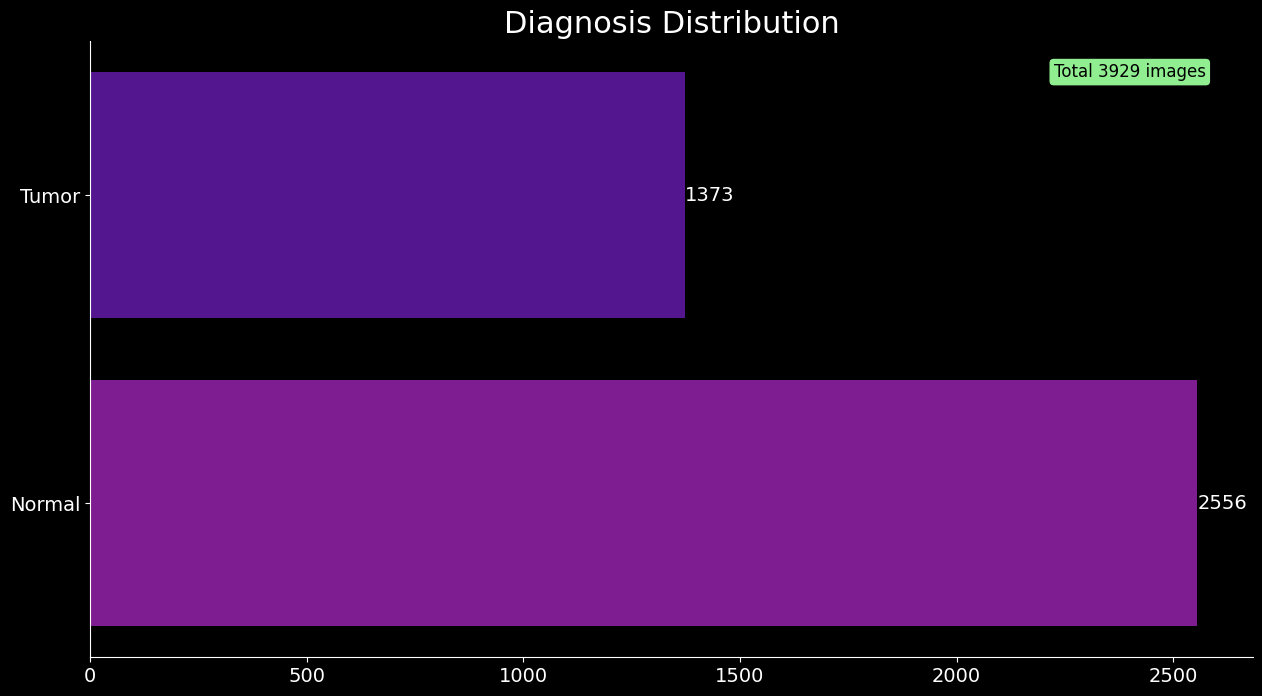

In [10]:
# View Diagnosis Distribution
fig = plt.figure(figsize=(15, 8))
plt.title('Diagnosis Distribution', fontsize=22);

diagnosis_distribution = ds['diagnosis'].value_counts().sort_values()
diagnosis_map = {0: 'Normal', 1: 'Tumor'}

bar_plot = sns.barplot(
    x=diagnosis_distribution.values,
    y=[diagnosis_map[_] for _ in diagnosis_distribution.keys()],
    palette=sns.color_palette("plasma"),
    orient="h"
);

for container in bar_plot.containers:
    bar_plot.bar_label(container, fmt='%.0f', fontsize=14);
    
plt.xticks(fontsize=14);
plt.yticks(fontsize=14);

text_params = {
    'x'       : 2400,
    'y'       : -0.4,
    's'       : f"Total {len(ds)} images", 
    'size'    : 12,
    'color'   : "black",
    'ha'      : "center", 
    'va'      : "center",
    'bbox'    : dict(boxstyle="round", fc=("lightgreen"),ec=("black"))
}
plt.text(**text_params);

sns.despine();

<a id='1.3'></a>
### Load & View Random Sample

In [11]:
def view_sample(image, mask, color_map='rgb', fig_size=(16, 8), title_size=18):
    fig = plt.figure(figsize=fig_size);
    fig.tight_layout();
    fig.subplots_adjust(top=0.95);
    
    # Plot MRI Image
    plt.subplot(1, 3, 1);
    plt.title(f'MRI Image', fontsize=title_size)
    if color_map=='rgb':
        plt.imshow(image)
    else:
        plt.imshow(image, cmap=color_map)
        
    # Plot Mask
    plt.subplot(1, 3, 2);
    plt.title(f'Mask', fontsize=title_size)
    plt.imshow(mask, cmap='gray');
    
    # Plot MRI w. Mask 
    plt.subplot(1, 3, 3);
    plt.title(f'MRI + Mask', fontsize=title_size)
    gen_mask = np.dstack([mask*0.1, mask*0.4, mask*0.1])
    
    if color_map=='rgb':
        plt.imshow(image + gen_mask, interpolation='none')
    else:
        plt.imshow(image + gen_mask, interpolation='none', cmap=color_map)
        
#     plt.imshow(mask, cmap='jet', interpolation='none', alpha=0.4);
    
    return

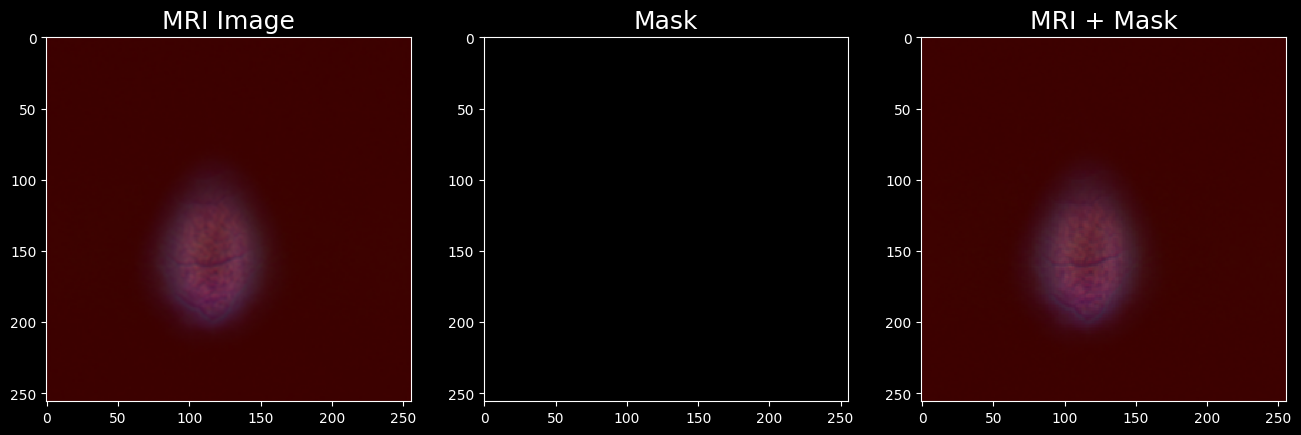

In [12]:
# Select random sample from train_df
idx = random.sample(ds.index.to_list(), 1)[0]

# Load the random sample and label
sample_image, sample_mask = _load(ds.image_path[idx]), _load(ds.mask_path[idx])

# View the random sample
view_sample(
    sample_image,
    sample_mask,
    color_map='rgb',
)

<a id='1.4'></a>
### Load & View Multiple Random Samples

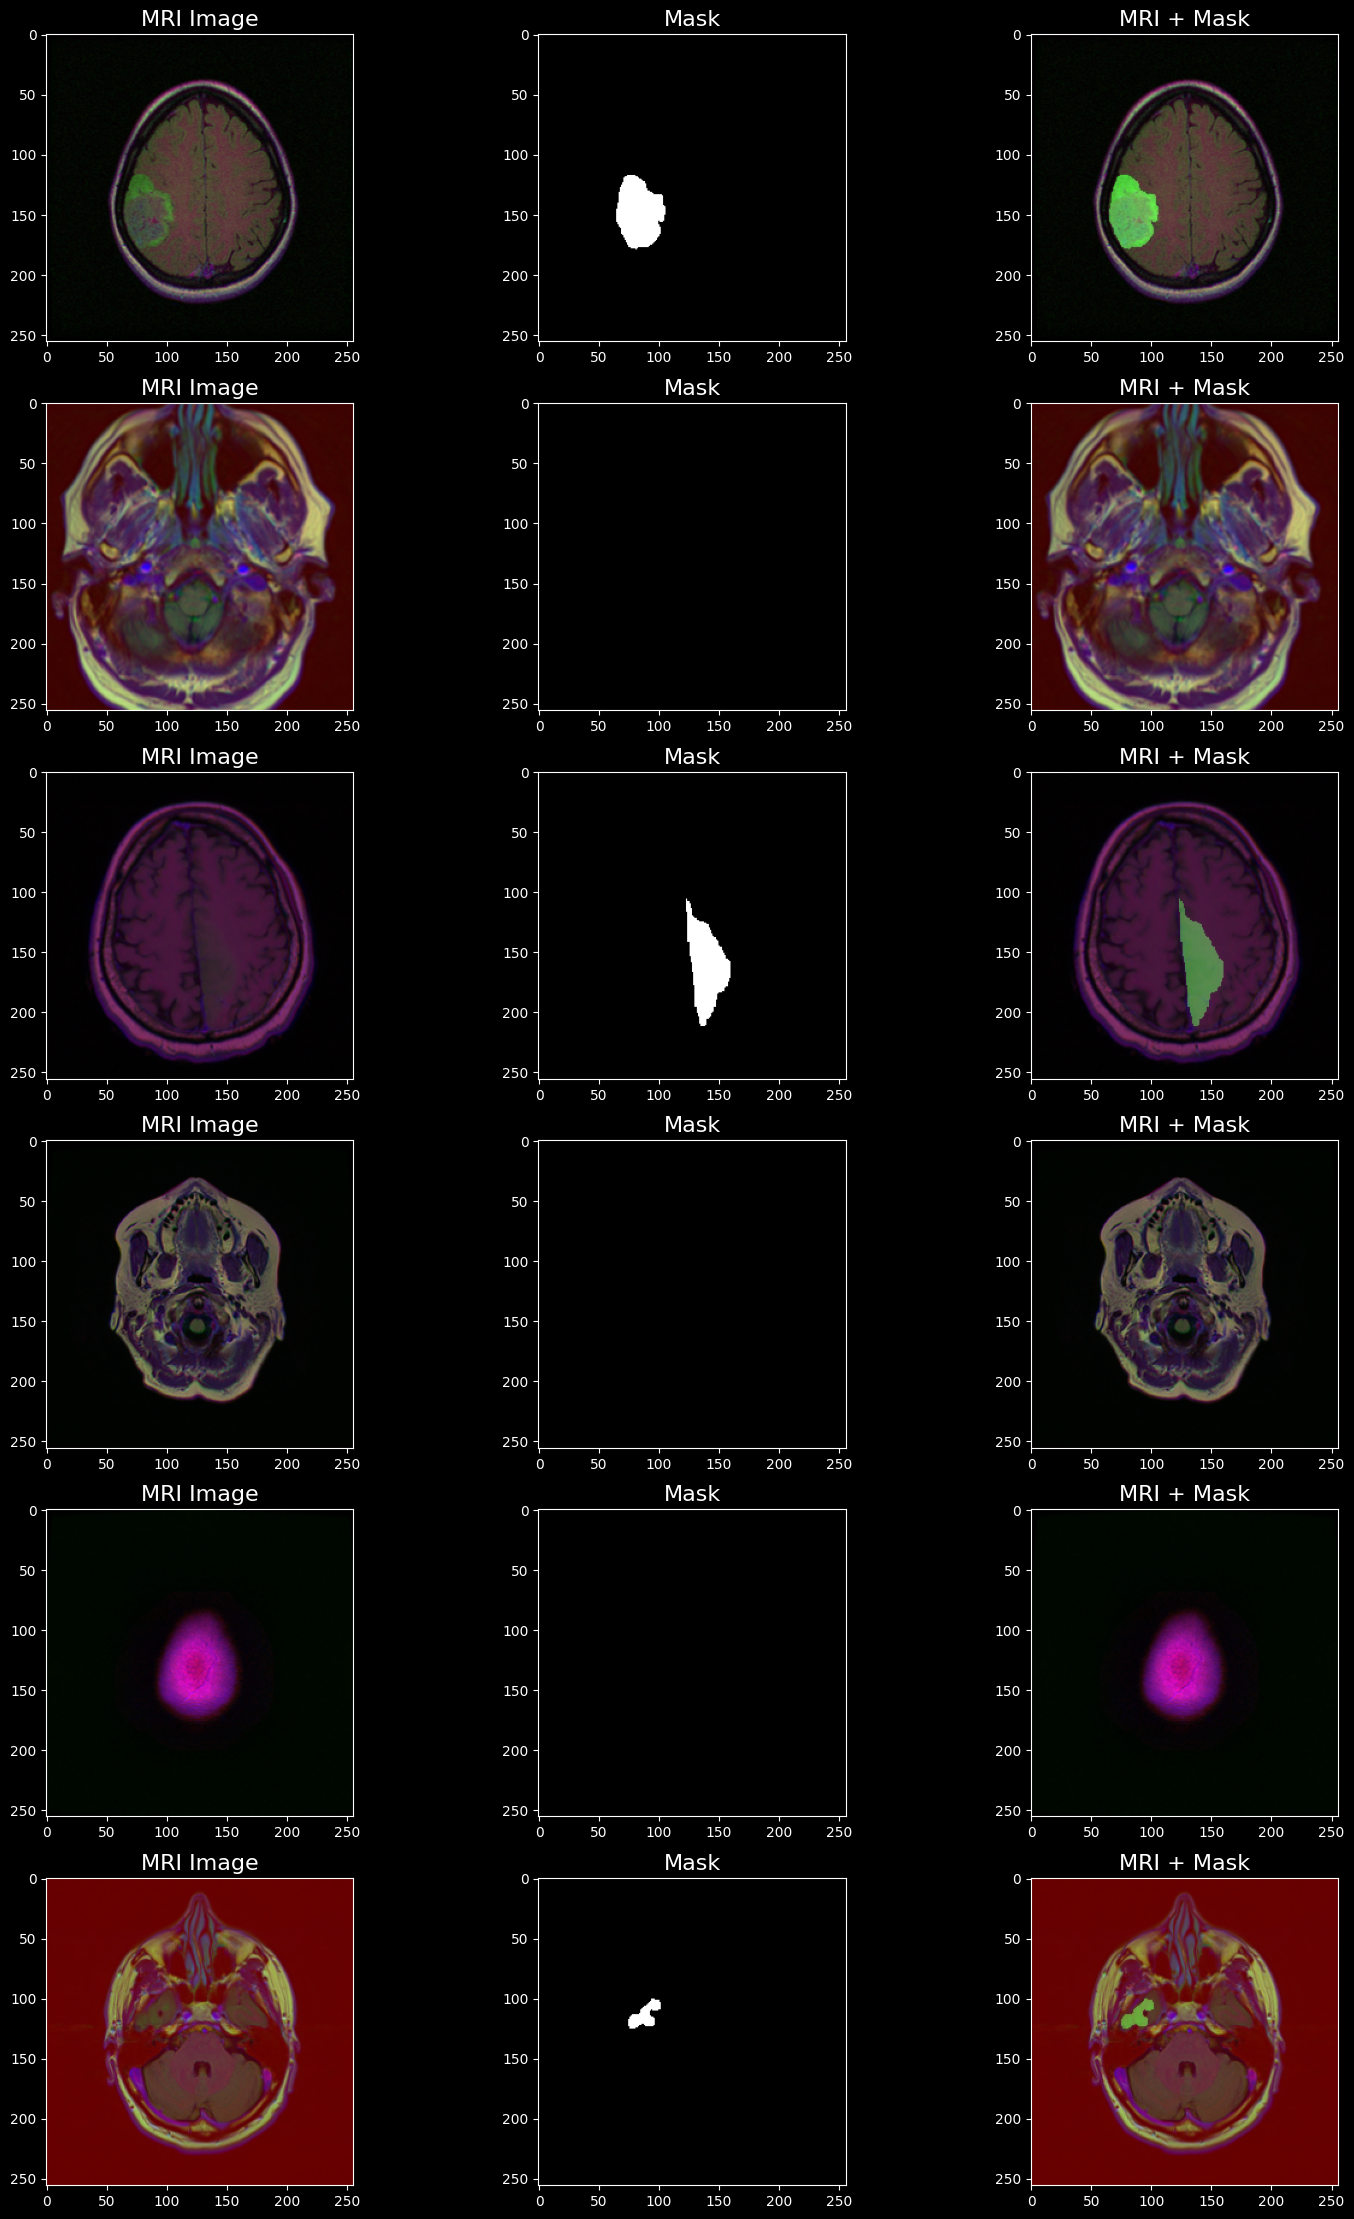

In [13]:
def view_mulitiple_samples(df, sample_loader, count=10, color_map='rgb', fig_size=(14, 10), title_size=16):
    idx = random.sample(df.index.to_list(), count)
    
    fig = plt.figure(figsize=fig_size);
    fig.tight_layout();
    fig.subplots_adjust(top=0.95);

    for row, _ in enumerate(idx):
        image, mask = (
            sample_loader(df.image_path[_]),#.permute(1, 2, 0),
            sample_loader(df.mask_path[_])#.permute(1, 2, 0)
        )
        
        idx = 3 * (row + 1)
        # Plot MRI Image
        plt.subplot(count+1, 3, idx + 1);
        plt.title(f'MRI Image', fontsize=title_size);
        if color_map=='rgb':
            plt.imshow(image)
        else:
            plt.imshow(image, cmap=color_map)

        # Plot Mask
        plt.subplot(count+1, 3, idx + 2);
        plt.title(f'Mask', fontsize=title_size)
        plt.imshow(mask, cmap='gray');

        # Plot MRI w. Mask 
        plt.subplot(count+1, 3, idx + 3);
        gen_mask = np.dstack([mask*0.1, mask*0.4, mask*0.1])
        plt.title(f'MRI + Mask', fontsize=title_size)
        if color_map=='rgb':
            plt.imshow(image + gen_mask)
        else:
            plt.imshow(image + gen_mask, cmap=color_map)

#         plt.imshow(mask, cmap='gray', alpha=0.5);

    return

# View 6 random sample images
view_mulitiple_samples(
    ds, _load, 
    count=6, color_map='mako',
    fig_size=(18, 30)
)

<a id='1.5'></a>
### Create Train, Validation and Test sets

In [14]:
# Create Train split 
train_split_idx, data_split_idx, _, _ = (
    train_test_split(
        ds.index, 
        ds.diagnosis, 
        test_size=0.30,
        stratify=ds.diagnosis,
        random_state=CFG.SEED
    )
)

# Get training and remaining data
train_df = ds.iloc[train_split_idx].reset_index(drop=True)
data_df = ds.iloc[data_split_idx].reset_index(drop=True)

# View shapes
train_df.shape, data_df.shape

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


((2750, 5), (1179, 5))

In [15]:
# Create Val/Test split 
val_split_idx, test_split_idx, _, _ = (
    train_test_split(
        data_df.index, 
        data_df.diagnosis, 
        test_size=0.65,
        stratify=data_df.diagnosis,
        random_state=CFG.SEED
    )
)

# Get training and remaining data
val_df = data_df.iloc[val_split_idx].reset_index(drop=True)
test_df = data_df.iloc[test_split_idx].reset_index(drop=True)

# View shapes
val_df.shape, test_df.shape

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


((412, 5), (767, 5))

In [16]:
train_size = len(train_df)
val_size = len(val_df)
test_size = len(test_df)
total = train_size + val_size + test_size

# View the counts
print(f'train samples count:\t\t{train_size}\t({(100 * train_size/total):.2f}%)')
print(f'validation samples count:\t{val_size}\t({(100 * val_size/total):.2f}%)')
print(f'test samples count:\t\t{test_size}\t({(100 * test_size/total):.2f}%)')
print('================================================')
print(f'TOTAL:\t\t\t\t{total}\t({(100 * total/total):.2f}%)')

train samples count:		2750	(69.99%)
validation samples count:	412	(10.49%)
test samples count:		767	(19.52%)
TOTAL:				3929	(100.00%)


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


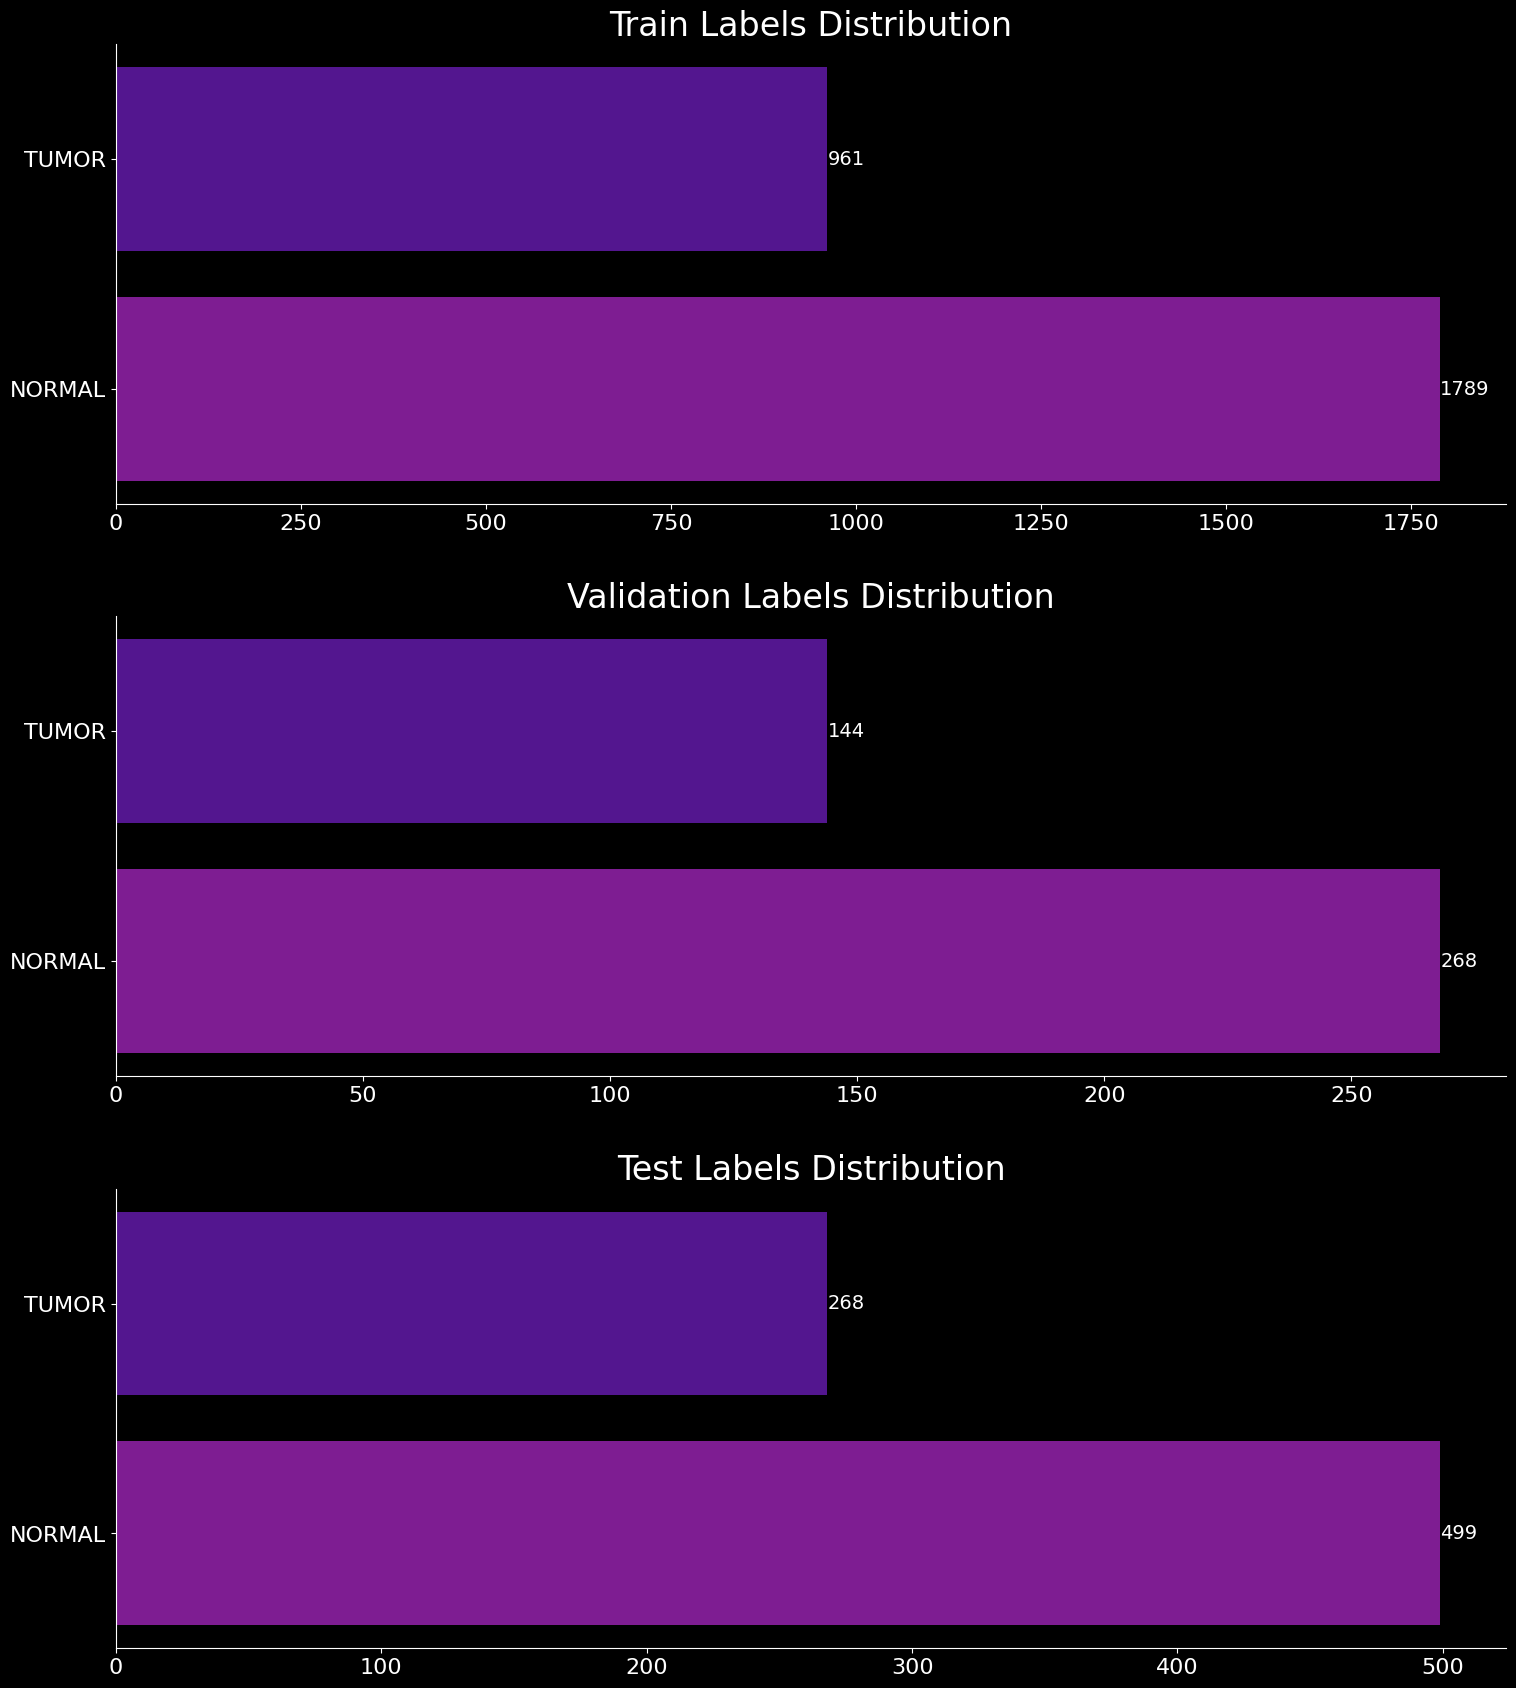

In [17]:
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(16, 18))

# Set the spacing between subplots
fig.tight_layout(pad=6.0)
sns.despine();


# Plot Train Labels Distribution
ax1.set_title('Train Labels Distribution', fontsize=24)
train_distribution = train_df['diagnosis'].value_counts().sort_values()
labels = {0: 'NORMAL', 1: 'TUMOR'}
bar_plot = sns.barplot(
    x=train_distribution.values,
    y=[labels[_] for _ in train_distribution.keys()],
    orient="h", palette=sns.color_palette("plasma"),
    ax=ax1
);

for container in bar_plot.containers:
    bar_plot.bar_label(container, fmt='%.0f', fontsize=14);

# Update axes tick parameters
ax1.tick_params(
    axis='both', which='major', 
    labelsize=16
);

# Plot Validation Labels Distribution
ax2.set_title('Validation Labels Distribution', fontsize=24)
val_distribution = val_df['diagnosis'].value_counts().sort_values()

bar_plot = sns.barplot(
    x=val_distribution.values,
    y=[labels[_] for _ in val_distribution.keys()],
    orient="h", palette=sns.color_palette("plasma"),
    ax=ax2
);

for container in bar_plot.containers:
    bar_plot.bar_label(container, fmt='%.0f', fontsize=14);

# Update axes tick parameters
ax2.tick_params(
    axis='both', which='major', 
    labelsize=16
);
    
# Plot Test Labels Distribution
ax3.set_title('Test Labels Distribution', fontsize=24)
test_distribution = test_df['diagnosis'].value_counts().sort_values()

bar_plot = sns.barplot(
    x=test_distribution.values,
    y=[labels[_] for _ in test_distribution.keys()],
    orient="h", palette=sns.color_palette("plasma"),
    ax=ax3
);

for container in bar_plot.containers:
    bar_plot.bar_label(container, fmt='%.0f', fontsize=14);
    
# Update axes tick parameters
ax3.tick_params(
    axis='both', which='major', 
    labelsize=16
);

<center><div style='color:#ffffff;
           display:inline-block;
           padding: 5px 5px 5px 5px;
           border-radius:5px;
           background-color:#78D1E1;
           font-size:100%;'><a href=#toc style='text-decoration: none; color:#03001C;'>⬆️ Back To Top</a></div></center>

<a id='2'></a>
# 2 | Build Custom Datasets & DataLoaders
<div style="padding: 4px;color:white;margin:10;font-size:200%;text-align:center;display:fill;border-radius:10px;overflow:hidden;background-image: url(https://i.postimg.cc/j2bBmHWx/Py-Torch-Gradient.jpg); background-size: 100% auto;"></div>

<br>

In order to train the model, we need to setup an input pipeline to load, preprocess and feed the input images to the model. This pipeline is required as loading all images at once into memory may cause an out of memory error to be raised. We also batch load images for efficient memory allocation.

For this pipeline, we'll use PyTorch's data API to contruct a dataloader and custom dataset/pipeline to load our images into memory for training and inference. We'll also use the transforms API from PyTorch's torchvision library to handle image augmentations for the training set images.

> See the following for more information:
> - [PyTorch | Transforming and Augmenting Images](https://pytorch.org/vision/stable/transforms.html)
> - [PyTorch | Datasets & Dataloaders](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html)
> - [PyTorch | Data API](https://pytorch.org/docs/stable/data.html)

<br>

<a id='2.1'></a>
### Define & Inspect Image Transforms

In [18]:
# Augment train data
train_transforms = A.Compose([
    A.Resize(CFG.HEIGHT, CFG.WIDTH, p=1.0),
    A.RandomBrightnessContrast(p=0.2),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    ToTensorV2(),
])

# Only reshape inference data
inference_transforms = A.Compose([
    A.Resize(CFG.HEIGHT, CFG.WIDTH, p=1.0),
    ToTensorV2(),
])

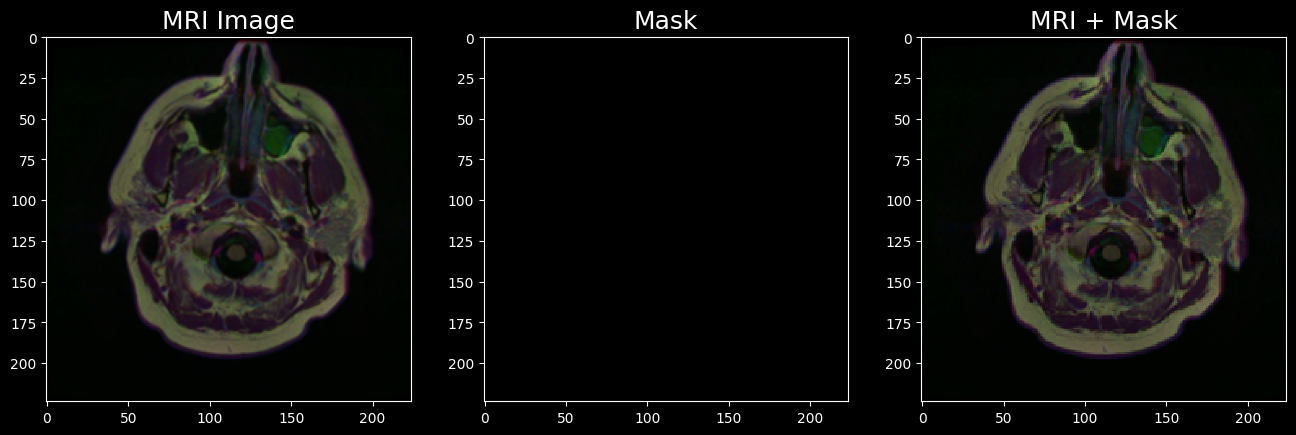

In [19]:
# Select random sample from train_df
idx = random.sample(ds.index.to_list(), 1)[0]

# Load the random sample and label
sample_image, sample_mask = _load(ds.image_path[idx]), _load(ds.mask_path[idx])

aug = train_transforms(image=sample_image, mask=sample_mask)

# View the random sample
view_sample(
    aug['image'].permute(1, 2, 0),
    aug['mask'].unsqueeze_(0).permute(1, 2, 0),
    color_map='mako',
)

In [20]:
class MRISegmetationDataset(Dataset):
    def __init__(self, df:pd.DataFrame, transform=None) -> None:
        super().__init__()
        
        self.mri_paths = df['image_path'].to_list()
        self.mask_paths = df['mask_path'].to_list()
#         self.labels = df['diagnosis'].to_list()
        self.transform = transform
        
#         self.classes = sorted(list(df['diagnosis'].unique()))
#         self.class_to_idx = {cls_name: _ for _, cls_name in enumerate(self.classes)}
        
    def load_sample(self, index:str) -> Image.Image:
        image_path = self.mri_paths[index]
        mask_path = self.mask_paths[index]
        
        image, mask = Image.open(image_path), Image.open(mask_path)
        
        image = np.array(image).astype(np.float32) / 255.
        mask = np.array(mask).astype(np.float32) / 255.
        
        return image, mask
        
    def __len__(self) -> int:
        return self.mri_paths.__len__()
    
    def __getitem__(self, index:int) -> Tuple[torch.Tensor, torch.Tensor]:
        image, mask = self.load_sample(index)
        
        # Transform if necessary
        if self.transform:
            transformed = self.transform(image=image, mask=mask)
            return transformed['image'], transformed['mask'].unsqueeze_(0)
        else:
            transformed = ToTensorV2()(image=image, mask=mask)    
            return transformed['image'], transformed['mask'].unsqueeze_(0)

<a id='2.2'></a>
### Build Custom Datasets

In [21]:
# Build train dataset
train_ds = MRISegmetationDataset(
    train_df, transform=train_transforms
)

# Build validation dataset
val_ds = MRISegmetationDataset(
    val_df, transform=inference_transforms
)

# Build test dataset
test_ds = MRISegmetationDataset(
    test_df, transform=inference_transforms
)

<a id='2.3'></a>
### Build DataLoaders from Custom Datasets

In [22]:
# Build train dataloader
train_loader = DataLoader(
    dataset=train_ds, 
    batch_size=CFG.BATCH_SIZE,
    num_workers=CFG.NUM_WORKERS,
    shuffle=CFG.APPLY_SHUFFLE
)

# Build validation dataloader
val_loader = DataLoader(
    dataset=val_ds, 
    batch_size=CFG.BATCH_SIZE,
    num_workers=CFG.NUM_WORKERS,
    shuffle=False
)

# Build test dataloader
test_loader = DataLoader(
    dataset=test_ds, 
    batch_size=CFG.BATCH_SIZE,
    num_workers=CFG.NUM_WORKERS,
    shuffle=False
)

<center><div style='color:#ffffff;
           display:inline-block;
           padding: 5px 5px 5px 5px;
           border-radius:5px;
           background-color:#78D1E1;
           font-size:100%;'><a href=#toc style='text-decoration: none; color:#03001C;'>⬆️ Back To Top</a></div></center>

<a id='3'></a>
# 3 | Write Custom Training Functions
<div style="padding: 4px;color:white;margin:10;font-size:200%;text-align:center;display:fill;border-radius:10px;overflow:hidden;background-image: url(https://i.postimg.cc/j2bBmHWx/Py-Torch-Gradient.jpg); background-size: 100% auto;"></div>

<br>

<a id='3.1'></a>
### Define Epoch Execution (Train Step)

In [23]:
def execute_epoch(
    model:torch.nn.Module,
    dataloader:torch.utils.data.DataLoader,
    optimizer:torch.optim.Optimizer,
    loss_fn:torch.nn.Module,
    device:torch.device) -> Tuple[float, float]:
    
    # Set model into training mode
    model.train()
    
    # Initialize train loss & accuracy
    train_loss, train_dice = 0, 0
    
    # Execute training loop over train dataloader
    for batch, (X, y) in enumerate(tqdm(dataloader)):
        # Load data onto target device
        X, y = X.to(device), y.to(device)
        
        # Feed-forward and compute metrics
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 
        
        # Reset Gradients & Backpropagate Loss
        optimizer.zero_grad()
        loss.backward()
        
        # Update Model Gradients
        optimizer.step()
        
        # Compute Batch Metrics
        predicted_class = torch.sigmoid(y_pred)
        predicted_class = (predicted_class > 0.5).float()
        
        eps = 1e-8
        train_dice += (
            (2 * (y * predicted_class).sum() + eps) / 
            ((y + predicted_class).sum() + eps)
        ).cpu().item()
        
        
    # Compute Step Metrics
    train_loss = train_loss / len(dataloader)
    train_dice = train_dice / len(dataloader)
    
    return train_loss, train_dice

<a id='3.2'></a>
### Define Evaluation Step

In [24]:
def evaluate(
    model:torch.nn.Module,
    dataloader:torch.utils.data.DataLoader,
    loss_fn:torch.nn.Module,
    device:torch.device) -> Tuple[float, float]:
    
    # Set model into eval mode
    model.eval()
    
    # Initialize eval loss & accuracy
    eval_loss, eval_dice = 0, 0
    
    # Active inferene context manager
    with torch.inference_mode():
        # Execute eval loop over dataloader
        for batch, (X, y) in enumerate(dataloader):
            # Load data onto target device
            X, y = X.to(device), y.to(device)

            # Feed-forward and compute metrics
            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            eval_loss += loss.item() 

            # Compute Batch Metrics
            predicted_class = torch.sigmoid(y_pred)
            predicted_class = (predicted_class > 0.5).float()
            
            eps = 1e-8
            eval_dice += (
                (2 * (y * predicted_class).sum() + eps) / 
                ((y + predicted_class).sum() + eps)
            ).cpu().item()
            
    # Compute Step Metrics
    eval_loss = eval_loss / len(dataloader)
    eval_dice = eval_dice / len(dataloader)
    
    return eval_loss, eval_dice

<a id='3.3'></a>
### Construct Training Loop

In [25]:
def train(
    model:torch.nn.Module,
    train_dataloader:torch.utils.data.DataLoader,
    eval_dataloader:torch.utils.data.DataLoader,
    optimizer:torch.optim.Optimizer,
    scheduler:torch.optim.lr_scheduler,
    loss_fn:torch.nn.Module,
    epochs:int,
    device:torch.device) -> Dict[str, List]:
    
    # Initialize training session
    session = {
        'loss'            : [],
        'dice_score'      : [],
        'eval_loss'       : [],
        'eval_dice_score' : []
    }
    
    # Training loop
    for epoch in tqdm(range(epochs)):
        # Execute Epoch
        print(f'\nEpoch {epoch + 1}/{epochs}')
        train_loss, train_dice = execute_epoch(
            model, 
            train_dataloader, 
            optimizer, 
            loss_fn, 
            device
        )
        
        # Evaluate Model
        eval_loss, eval_dice = evaluate(
            model, 
            eval_dataloader,
            loss_fn, 
            device
        )
        
        # Execute schedular step
        current_lr = 0
        if scheduler: 
            scheduler.step(eval_loss)
            current_lr = optimizer.param_groups[0]['lr']
        
        # Log Epoch Metrics
        log_text = f'loss: {train_loss:.4f} - dice_score: {train_dice:.4f} - eval_loss: {eval_loss:.4f} - eval_dice_score: {eval_dice:.4f}'
        
        if scheduler: 
            print(log_text + f' - lr: {current_lr}')
        else:
            print(log_text)
            
        # Record Epoch Metrics
        session['loss'].append(train_loss)
        session['dice_score'].append(train_dice)
        session['eval_loss'].append(eval_loss)
        session['eval_dice_score'].append(eval_dice)
        
    # Return Session Metrics
    return session

<a id='3.4'></a>
### Construct Predict Function

In [26]:
def predict(
    model:nn.Module, 
    sample_loader:torch.utils.data.DataLoader,
    device:torch.device,
    threshold:float=0.5) -> np.ndarray:
    
    # Set model into eval mode
    model.eval()
    
    predictions = []
    
    # Active inferene context manager
    with torch.inference_mode():
        # Execute eval loop over dataloader
        for batch, (X, y) in enumerate(tqdm(sample_loader)):
            # Load data onto target device
            X, y = X.to(device), y.to(device)

            # Feed-forward and compute metrics
            y_pred = model(X) 

            # Compute Batch Metrics
            predicted_class = torch.sigmoid(y_pred)
            predicted_class = (predicted_class >= threshold).float()

            # Record prediction
            predictions.append(predicted_class.cpu().numpy())
        
    return np.vstack(predictions)

<center><div style='color:#ffffff;
           display:inline-block;
           padding: 5px 5px 5px 5px;
           border-radius:5px;
           background-color:#78D1E1;
           font-size:100%;'><a href=#toc style='text-decoration: none; color:#03001C;'>⬆️ Back To Top</a></div></center>

<a id='4'></a>
# 4 | Implementing U-Net Architecture (Research Paper)
<div style="padding: 4px;color:white;margin:10;font-size:200%;text-align:center;display:fill;border-radius:10px;overflow:hidden;background-image: url(https://i.postimg.cc/j2bBmHWx/Py-Torch-Gradient.jpg); background-size: 100% auto;"></div>

<br>
 
The U-Net architecture, which was introduced in 2015, has been a game-changer in the field of deep learning. The architecture won the International Syposium on Biomedical Imaging (ISBI) cell tracking challenge conducted in 2015 by a significant margin in several categories such as phase constrast and DIC microscopy, both of which fall under the transmitted light microscopy tasks.

<br>

<center>
    <figure>
        <img src="https://i.postimg.cc/Pxz6NFjw/UNet-Architecture.png" alt ="U-Net Architecture" style='width:75%;'>
        <figcaption>
            Source: U-Net architecture diagram from <a href="https://arxiv.org/pdf/1505.04597.pdf">paper</a>.
        </figcaption>
    </figure>
</center>

<br>


The architecture is comprised of two paths - the contracting path (on the left) and the expansive path (on the right). The contracting path (encoder) adheres to the conventional architecture of a convolutional network. It consists of repeatedly applying blocks of two 3x3 convolutions (without padding), followed by a rectified linear unit (ReLU) and a 2x2 max pooling (with stride 2) operation that reduces the size of the features by half. At each downsampling step, the number of feature channels is doubled. We will refer to these blocks as Double Convolutional blocks.


Each step in the expansive path (decoder) involves upsampling the feature map, followed by a 2x2 convolution (known as an "up-convolution") that reduces the number of feature channels by half. This is then concatenated with the feature map from the contracting path that has been correspondingly cropped, and two 3x3 convolutions are applied to it, each followed by a ReLU activation. The cropping is necessary due to the border pixels that are lost at every convolution. At the final layer, a 1x1 convolution is utilized to map each 64-component feature vector to the desired number of classes.

In [27]:
from IPython.display import HTML
html_embed = """
<iframe 
    width="700" height="400" 
    src="https://www.youtube.com/embed/81AvQQnpG4Q?si=q4jCb6CHqPWNGZ8u" 
    title="YouTube video player" frameborder="0" allow="accelerometer; 
    autoplay; clipboard-write; encrypted-media; 
    gyroscope; picture-in-picture; 
    web-share" allowfullscreen>
</iframe>
"""

HTML(f'<div align="center">{html_embed}</div>')

In this section we will implement, generate and visualize the U-Net architecture in PyTorch.

For more information, kindly see the following:
> - [arXiv | U-Net Architecture Paper](https://arxiv.org/abs/1505.04597)
> - [Freinburg University | U-Net: Convolutional Networks for Biomedical Image Segmentation](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/)
> - [SuperAnnotate | Complete guide to semantic segmentation [Updated 2023]](https://www.superannotate.com/blog/guide-to-semantic-segmentation)

<br>

<a id='4.1'></a>
### Define Double Convolution Block

In [28]:
class DoubleConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConvBlock, self).__init__()
        
        self.conv1 = nn.Conv2d(
            in_channels, out_channels, 
            kernel_size=3, stride=1, 
            padding=1, bias=False
        )
        self.conv2 = nn.Conv2d(
            out_channels, out_channels, 
            kernel_size=3, stride=1, 
            padding=1, bias=False
        )

        self.batchnorm1 = nn.BatchNorm2d(out_channels)
        self.batchnorm2 = nn.BatchNorm2d(out_channels)
        
        self.relu1 = nn.ReLU(inplace=True)
        self.relu2 = nn.ReLU(inplace=True)
        
        
    def forward(self, x):
        # First Convolution
        x = self.conv1(x)
        x = self.batchnorm1(x)
        x = self.relu1(x)
        
        # Second Convolution
        x = self.conv2(x)
        x = self.batchnorm2(x)
        
        return self.relu2(x)

<a id='4.2'></a>
### Implement U-Net Model Architecture

In [29]:
class UNetModel(nn.Module):
    def __init__(
        self, in_channels:int=3, 
        out_channels:int=1, 
        block_sizes:Tuple[int]=(64, 128, 256, 512)
    ):
        super(UNetModel, self).__init__()
        # Initialise model encoder & decoder using torch ModuleLists
        self.encoder, self.decoder = nn.ModuleList(), nn.ModuleList()
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2) 
        
        # Create Encoder
        for block_size in block_sizes:
            self.encoder.append(DoubleConvBlock(in_channels, block_size))
            in_channels = block_size
            
        # Create Decoder
        for block_size in block_sizes[::-1]:
            self.decoder.append(
                nn.ConvTranspose2d(2 * block_size, block_size, kernel_size=2, stride=2)
            )
            self.decoder.append(DoubleConvBlock(2 * block_size, block_size))
        
        # Create Bottleneck
        last_blocksize = block_sizes[-1]
        self.bottleneck = DoubleConvBlock(last_blocksize, 2 * last_blocksize)
        
        # Create Output Layer
        self.output_conv = nn.Conv2d(block_sizes[0], out_channels, kernel_size=1)
        
    def forward(self, x):
        concatenations = []
        concatenations.append(x)
        
        # Propagate input downstream (Encode Input)
        for encoder_layer in self.encoder:
            x = encoder_layer(x)
            concatenations.append(x)
            x = self.max_pool(x)
            
        # Execute bottleneck
        x = self.bottleneck(x)
        concatenations = concatenations[::-1]
        
        # Propagate input upstream (Decode Input) & concatenate layers
        for _ in range(0, len(self.decoder), 2):
            x = self.decoder[_](x)
            encoder_layer = concatenations[_ // 2]
            
            # Concatenate corrensponding encoder layer to decoder layer output
            concat_layer = torch.cat(
                (encoder_layer, x), dim=1
            )
            
            x = self.decoder[_ + 1](concat_layer)
            
        # Return predicted logits    
        return self.output_conv(x)

<a id='4.3'></a>
### Generate U-Net Model

In [30]:
# Define U-Net Params
unet_params = {
    'in_channels'    : 3,
    'out_channels'   : 1,
    'block_sizes'    : (64, 128, 256, 512)
}

# Generate Model & Push to Device
unet_model = UNetModel(**unet_params).to(CFG.DEVICE)

# If using GPU T4 x2 setup, use this:
if CFG.NUM_DEVICES > 1:
    unet_model = nn.DataParallel(unet_model)

In [31]:
# View model summary
summary(
    model=unet_model, 
    input_size=(CFG.BATCH_SIZE, CFG.CHANNELS, CFG.WIDTH, CFG.HEIGHT),
    col_names=["output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"]
)

Layer (type (var_name))                       Output Shape         Param #              Trainable
DataParallel (DataParallel)                   [64, 1, 224, 224]    --                   True
├─UNetModel (module)                          [32, 1, 224, 224]    31,037,633           True
├─UNetModel (module)                          --                   (recursive)          True
│    └─ModuleList (encoder)                   --                   (recursive)          True
│    │    └─DoubleConvBlock (0)               [32, 64, 224, 224]   38,848               True
│    │    └─DoubleConvBlock (0)               --                   (recursive)          True
├─UNetModel (module)                          [32, 1, 224, 224]    --                   --
├─UNetModel (module)                          --                   (recursive)          True
│    └─ModuleList (encoder)                   --                   (recursive)          True
│    │    └─DoubleConvBlock (0)               [32, 64, 224, 224]   

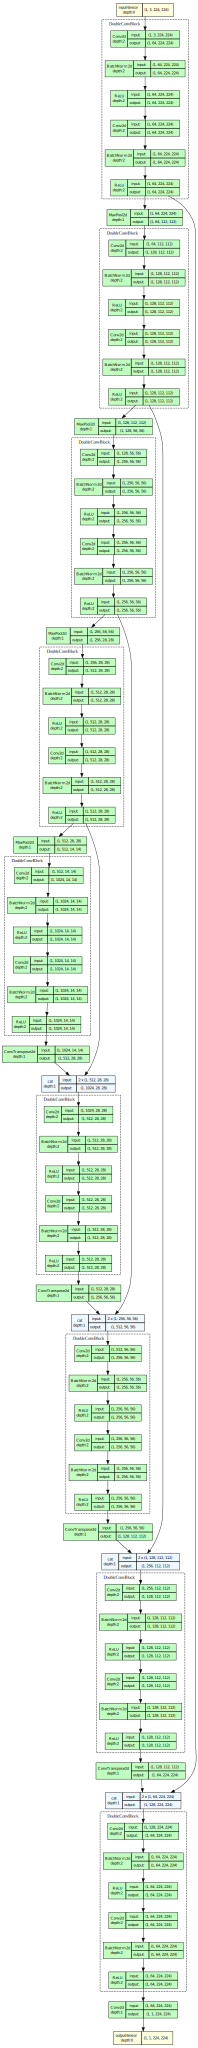

In [32]:
# Generate Model Computation Graph
model_graph = draw_graph(
    UNetModel(), 
    input_size=(1, CFG.CHANNELS, CFG.WIDTH, CFG.HEIGHT), 
    expand_nested=True
)

# View Model Architecture
model_graph.visual_graph

<a id='4.4'></a>
### Initiate Model Loss, Optimizer & LR Scheduler

In [33]:
# Define Loss Function
loss_fn = nn.BCEWithLogitsLoss()

# Define Optimizer
optimizer = torch.optim.AdamW(
    unet_model.parameters(),
    lr=CFG.LR
)

# Define Scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(
    optimizer=optimizer, 
    mode='min',
    patience=CFG.PATIENS,
    verbose=True
)

<a id='4.5'></a>
### Train U-Net Model

In [34]:
print('Training U-Net Model')
print(f'Train on {len(train_df)} samples, validate on {len(val_df)} samples.')
print('----------------------------------')

# Generate training session config 
session_config = {
    'model'               : unet_model,
    'train_dataloader'    : train_loader,
    'eval_dataloader'     : val_loader,
    'optimizer'           : optimizer,
    'scheduler'           : scheduler,
    'loss_fn'             : loss_fn,
    'epochs'              : CFG.EPOCHS,
    'device'              : CFG.DEVICE
}

# Execute Training Session
unet_session_history = train(**session_config)

Training U-Net Model
Train on 2750 samples, validate on 412 samples.
----------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]


Epoch 1/100


  0%|          | 0/43 [00:00<?, ?it/s]

loss: 0.3785 - dice_score: 0.3178 - eval_loss: 0.3204 - eval_dice_score: 0.0716 - lr: 0.0001

Epoch 2/100


  0%|          | 0/43 [00:00<?, ?it/s]

loss: 0.2643 - dice_score: 0.4844 - eval_loss: 0.2505 - eval_dice_score: 0.5524 - lr: 0.0001

Epoch 3/100


  0%|          | 0/43 [00:00<?, ?it/s]

loss: 0.2344 - dice_score: 0.5522 - eval_loss: 0.2256 - eval_dice_score: 0.5928 - lr: 0.0001

Epoch 4/100


  0%|          | 0/43 [00:00<?, ?it/s]

loss: 0.2141 - dice_score: 0.5912 - eval_loss: 0.2053 - eval_dice_score: 0.6658 - lr: 0.0001

Epoch 5/100


  0%|          | 0/43 [00:00<?, ?it/s]

loss: 0.1952 - dice_score: 0.6439 - eval_loss: 0.1853 - eval_dice_score: 0.7195 - lr: 0.0001

Epoch 6/100


  0%|          | 0/43 [00:00<?, ?it/s]

loss: 0.1796 - dice_score: 0.6691 - eval_loss: 0.1752 - eval_dice_score: 0.7289 - lr: 0.0001

Epoch 7/100


  0%|          | 0/43 [00:00<?, ?it/s]

loss: 0.1655 - dice_score: 0.6797 - eval_loss: 0.1562 - eval_dice_score: 0.7311 - lr: 0.0001

Epoch 8/100


  0%|          | 0/43 [00:00<?, ?it/s]

loss: 0.1528 - dice_score: 0.6778 - eval_loss: 0.1427 - eval_dice_score: 0.7195 - lr: 0.0001

Epoch 9/100


  0%|          | 0/43 [00:00<?, ?it/s]

loss: 0.1406 - dice_score: 0.7189 - eval_loss: 0.1333 - eval_dice_score: 0.7300 - lr: 0.0001

Epoch 10/100


  0%|          | 0/43 [00:00<?, ?it/s]

loss: 0.1305 - dice_score: 0.7219 - eval_loss: 0.1241 - eval_dice_score: 0.7549 - lr: 0.0001

Epoch 11/100


  0%|          | 0/43 [00:00<?, ?it/s]

loss: 0.1208 - dice_score: 0.7313 - eval_loss: 0.1262 - eval_dice_score: 0.6557 - lr: 0.0001

Epoch 12/100


  0%|          | 0/43 [00:00<?, ?it/s]

loss: 0.1127 - dice_score: 0.7342 - eval_loss: 0.1093 - eval_dice_score: 0.7534 - lr: 0.0001

Epoch 13/100


  0%|          | 0/43 [00:00<?, ?it/s]

loss: 0.1041 - dice_score: 0.7622 - eval_loss: 0.1005 - eval_dice_score: 0.7635 - lr: 0.0001

Epoch 14/100


  0%|          | 0/43 [00:00<?, ?it/s]

loss: 0.0974 - dice_score: 0.7543 - eval_loss: 0.0932 - eval_dice_score: 0.8031 - lr: 0.0001

Epoch 15/100


  0%|          | 0/43 [00:00<?, ?it/s]

loss: 0.0916 - dice_score: 0.7502 - eval_loss: 0.0841 - eval_dice_score: 0.7611 - lr: 0.0001

Epoch 16/100


  0%|          | 0/43 [00:00<?, ?it/s]

loss: 0.0852 - dice_score: 0.7658 - eval_loss: 0.0833 - eval_dice_score: 0.7859 - lr: 0.0001

Epoch 17/100


  0%|          | 0/43 [00:00<?, ?it/s]

loss: 0.0799 - dice_score: 0.7779 - eval_loss: 0.0817 - eval_dice_score: 0.7410 - lr: 0.0001

Epoch 18/100


  0%|          | 0/43 [00:00<?, ?it/s]

loss: 0.0747 - dice_score: 0.7926 - eval_loss: 0.0729 - eval_dice_score: 0.8427 - lr: 0.0001

Epoch 19/100


  0%|          | 0/43 [00:00<?, ?it/s]

loss: 0.0697 - dice_score: 0.8071 - eval_loss: 0.0689 - eval_dice_score: 0.8109 - lr: 0.0001

Epoch 20/100


  0%|          | 0/43 [00:00<?, ?it/s]

loss: 0.0651 - dice_score: 0.8153 - eval_loss: 0.0639 - eval_dice_score: 0.8367 - lr: 0.0001

Epoch 21/100


  0%|          | 0/43 [00:00<?, ?it/s]

loss: 0.0613 - dice_score: 0.8262 - eval_loss: 0.0600 - eval_dice_score: 0.8523 - lr: 0.0001

Epoch 22/100


  0%|          | 0/43 [00:00<?, ?it/s]

loss: 0.0572 - dice_score: 0.8422 - eval_loss: 0.0552 - eval_dice_score: 0.8465 - lr: 0.0001

Epoch 23/100


  0%|          | 0/43 [00:00<?, ?it/s]

loss: 0.0544 - dice_score: 0.8331 - eval_loss: 0.0525 - eval_dice_score: 0.8538 - lr: 0.0001

Epoch 24/100


  0%|          | 0/43 [00:00<?, ?it/s]

loss: 0.0511 - dice_score: 0.8414 - eval_loss: 0.0496 - eval_dice_score: 0.8602 - lr: 0.0001

Epoch 25/100


  0%|          | 0/43 [00:00<?, ?it/s]

loss: 0.0481 - dice_score: 0.8551 - eval_loss: 0.0465 - eval_dice_score: 0.8684 - lr: 0.0001

Epoch 26/100


  0%|          | 0/43 [00:00<?, ?it/s]

loss: 0.0459 - dice_score: 0.8512 - eval_loss: 0.0440 - eval_dice_score: 0.8542 - lr: 0.0001

Epoch 27/100


  0%|          | 0/43 [00:00<?, ?it/s]

loss: 0.0434 - dice_score: 0.8542 - eval_loss: 0.0424 - eval_dice_score: 0.8646 - lr: 0.0001

Epoch 28/100


  0%|          | 0/43 [00:00<?, ?it/s]

loss: 0.0414 - dice_score: 0.8553 - eval_loss: 0.0418 - eval_dice_score: 0.8556 - lr: 0.0001

Epoch 29/100


  0%|          | 0/43 [00:00<?, ?it/s]

loss: 0.0393 - dice_score: 0.8632 - eval_loss: 0.0393 - eval_dice_score: 0.8398 - lr: 0.0001

Epoch 30/100


  0%|          | 0/43 [00:00<?, ?it/s]

loss: 0.0376 - dice_score: 0.8589 - eval_loss: 0.0360 - eval_dice_score: 0.8738 - lr: 0.0001

Epoch 31/100


  0%|          | 0/43 [00:00<?, ?it/s]

loss: 0.0357 - dice_score: 0.8653 - eval_loss: 0.0352 - eval_dice_score: 0.8723 - lr: 0.0001

Epoch 32/100


  0%|          | 0/43 [00:00<?, ?it/s]

loss: 0.0339 - dice_score: 0.8729 - eval_loss: 0.0332 - eval_dice_score: 0.8780 - lr: 0.0001

Epoch 33/100


  0%|          | 0/43 [00:00<?, ?it/s]

loss: 0.0325 - dice_score: 0.8717 - eval_loss: 0.0311 - eval_dice_score: 0.8818 - lr: 0.0001

Epoch 34/100


  0%|          | 0/43 [00:00<?, ?it/s]

loss: 0.0312 - dice_score: 0.8695 - eval_loss: 0.0299 - eval_dice_score: 0.8761 - lr: 0.0001

Epoch 35/100


  0%|          | 0/43 [00:00<?, ?it/s]

loss: 0.0302 - dice_score: 0.8686 - eval_loss: 0.0303 - eval_dice_score: 0.8729 - lr: 0.0001

Epoch 36/100


  0%|          | 0/43 [00:00<?, ?it/s]

loss: 0.0288 - dice_score: 0.8731 - eval_loss: 0.0278 - eval_dice_score: 0.8777 - lr: 0.0001

Epoch 37/100


  0%|          | 0/43 [00:00<?, ?it/s]

loss: 0.0275 - dice_score: 0.8781 - eval_loss: 0.0266 - eval_dice_score: 0.8733 - lr: 0.0001

Epoch 38/100


  0%|          | 0/43 [00:00<?, ?it/s]

loss: 0.0264 - dice_score: 0.8792 - eval_loss: 0.0261 - eval_dice_score: 0.8856 - lr: 0.0001

Epoch 39/100


  0%|          | 0/43 [00:00<?, ?it/s]

loss: 0.0256 - dice_score: 0.8749 - eval_loss: 0.0247 - eval_dice_score: 0.8847 - lr: 0.0001

Epoch 40/100


  0%|          | 0/43 [00:00<?, ?it/s]

loss: 0.0245 - dice_score: 0.8822 - eval_loss: 0.0241 - eval_dice_score: 0.8830 - lr: 0.0001

Epoch 41/100


  0%|          | 0/43 [00:00<?, ?it/s]

loss: 0.0237 - dice_score: 0.8821 - eval_loss: 0.0236 - eval_dice_score: 0.8740 - lr: 0.0001

Epoch 42/100


  0%|          | 0/43 [00:00<?, ?it/s]

loss: 0.0226 - dice_score: 0.8890 - eval_loss: 0.0222 - eval_dice_score: 0.8730 - lr: 0.0001

Epoch 43/100


  0%|          | 0/43 [00:00<?, ?it/s]

loss: 0.0220 - dice_score: 0.8844 - eval_loss: 0.0209 - eval_dice_score: 0.8828 - lr: 0.0001

Epoch 44/100


  0%|          | 0/43 [00:00<?, ?it/s]

loss: 0.0210 - dice_score: 0.8868 - eval_loss: 0.0211 - eval_dice_score: 0.8730 - lr: 0.0001

Epoch 45/100


  0%|          | 0/43 [00:00<?, ?it/s]

loss: 0.0204 - dice_score: 0.8857 - eval_loss: 0.0232 - eval_dice_score: 0.8328 - lr: 0.0001

Epoch 46/100


  0%|          | 0/43 [00:00<?, ?it/s]

loss: 0.0203 - dice_score: 0.8789 - eval_loss: 0.0202 - eval_dice_score: 0.8712 - lr: 0.0001

Epoch 47/100


  0%|          | 0/43 [00:00<?, ?it/s]

loss: 0.0192 - dice_score: 0.8883 - eval_loss: 0.0183 - eval_dice_score: 0.8924 - lr: 0.0001

Epoch 48/100


  0%|          | 0/43 [00:00<?, ?it/s]

loss: 0.0186 - dice_score: 0.8898 - eval_loss: 0.0183 - eval_dice_score: 0.8894 - lr: 0.0001

Epoch 49/100


  0%|          | 0/43 [00:00<?, ?it/s]

loss: 0.0183 - dice_score: 0.8833 - eval_loss: 0.0190 - eval_dice_score: 0.8687 - lr: 0.0001

Epoch 50/100


  0%|          | 0/43 [00:00<?, ?it/s]

loss: 0.0183 - dice_score: 0.8748 - eval_loss: 0.0185 - eval_dice_score: 0.8844 - lr: 0.0001

Epoch 51/100


  0%|          | 0/43 [00:00<?, ?it/s]

loss: 0.0172 - dice_score: 0.8868 - eval_loss: 0.0165 - eval_dice_score: 0.8923 - lr: 0.0001

Epoch 52/100


  0%|          | 0/43 [00:00<?, ?it/s]

loss: 0.0167 - dice_score: 0.8870 - eval_loss: 0.0171 - eval_dice_score: 0.8812 - lr: 0.0001

Epoch 53/100


  0%|          | 0/43 [00:00<?, ?it/s]

loss: 0.0160 - dice_score: 0.8924 - eval_loss: 0.0157 - eval_dice_score: 0.8911 - lr: 0.0001

Epoch 54/100


  0%|          | 0/43 [00:00<?, ?it/s]

loss: 0.0153 - dice_score: 0.8987 - eval_loss: 0.0154 - eval_dice_score: 0.8900 - lr: 0.0001

Epoch 55/100


  0%|          | 0/43 [00:00<?, ?it/s]

loss: 0.0148 - dice_score: 0.8970 - eval_loss: 0.0154 - eval_dice_score: 0.8847 - lr: 0.0001

Epoch 56/100


  0%|          | 0/43 [00:00<?, ?it/s]

loss: 0.0144 - dice_score: 0.8994 - eval_loss: 0.0154 - eval_dice_score: 0.8920 - lr: 0.0001

Epoch 57/100


  0%|          | 0/43 [00:00<?, ?it/s]

loss: 0.0140 - dice_score: 0.9016 - eval_loss: 0.0145 - eval_dice_score: 0.8973 - lr: 0.0001

Epoch 58/100


  0%|          | 0/43 [00:00<?, ?it/s]

loss: 0.0138 - dice_score: 0.8984 - eval_loss: 0.0144 - eval_dice_score: 0.8865 - lr: 0.0001

Epoch 59/100


  0%|          | 0/43 [00:00<?, ?it/s]

loss: 0.0133 - dice_score: 0.9007 - eval_loss: 0.0143 - eval_dice_score: 0.8919 - lr: 0.0001

Epoch 60/100


  0%|          | 0/43 [00:00<?, ?it/s]

loss: 0.0129 - dice_score: 0.9027 - eval_loss: 0.0134 - eval_dice_score: 0.8840 - lr: 0.0001

Epoch 61/100


  0%|          | 0/43 [00:00<?, ?it/s]

loss: 0.0127 - dice_score: 0.9011 - eval_loss: 0.0129 - eval_dice_score: 0.8889 - lr: 0.0001

Epoch 62/100


  0%|          | 0/43 [00:00<?, ?it/s]

loss: 0.0124 - dice_score: 0.9001 - eval_loss: 0.0128 - eval_dice_score: 0.8978 - lr: 0.0001

Epoch 63/100


  0%|          | 0/43 [00:00<?, ?it/s]

loss: 0.0120 - dice_score: 0.9049 - eval_loss: 0.0133 - eval_dice_score: 0.8904 - lr: 0.0001

Epoch 64/100


  0%|          | 0/43 [00:00<?, ?it/s]

loss: 0.0117 - dice_score: 0.9063 - eval_loss: 0.0123 - eval_dice_score: 0.8904 - lr: 0.0001

Epoch 65/100


  0%|          | 0/43 [00:00<?, ?it/s]

loss: 0.0116 - dice_score: 0.9043 - eval_loss: 0.0116 - eval_dice_score: 0.8944 - lr: 0.0001

Epoch 66/100


  0%|          | 0/43 [00:00<?, ?it/s]

loss: 0.0116 - dice_score: 0.9001 - eval_loss: 0.0122 - eval_dice_score: 0.8883 - lr: 0.0001

Epoch 67/100


  0%|          | 0/43 [00:00<?, ?it/s]

loss: 0.0111 - dice_score: 0.9039 - eval_loss: 0.0112 - eval_dice_score: 0.8974 - lr: 0.0001

Epoch 68/100


  0%|          | 0/43 [00:00<?, ?it/s]

loss: 0.0110 - dice_score: 0.9019 - eval_loss: 0.0115 - eval_dice_score: 0.8843 - lr: 0.0001

Epoch 69/100


  0%|          | 0/43 [00:00<?, ?it/s]

loss: 0.0108 - dice_score: 0.8992 - eval_loss: 0.0106 - eval_dice_score: 0.8978 - lr: 0.0001

Epoch 70/100


  0%|          | 0/43 [00:00<?, ?it/s]

loss: 0.0106 - dice_score: 0.9012 - eval_loss: 0.0109 - eval_dice_score: 0.9008 - lr: 0.0001

Epoch 71/100


  0%|          | 0/43 [00:00<?, ?it/s]

loss: 0.0104 - dice_score: 0.9007 - eval_loss: 0.0114 - eval_dice_score: 0.8761 - lr: 0.0001

Epoch 72/100


  0%|          | 0/43 [00:00<?, ?it/s]

loss: 0.0109 - dice_score: 0.8894 - eval_loss: 0.0111 - eval_dice_score: 0.8916 - lr: 0.0001

Epoch 73/100


  0%|          | 0/43 [00:00<?, ?it/s]

loss: 0.0100 - dice_score: 0.9009 - eval_loss: 0.0102 - eval_dice_score: 0.8915 - lr: 0.0001

Epoch 74/100


  0%|          | 0/43 [00:00<?, ?it/s]

loss: 0.0100 - dice_score: 0.9017 - eval_loss: 0.0101 - eval_dice_score: 0.8933 - lr: 0.0001

Epoch 75/100


  0%|          | 0/43 [00:00<?, ?it/s]

loss: 0.0092 - dice_score: 0.9112 - eval_loss: 0.0102 - eval_dice_score: 0.8916 - lr: 0.0001

Epoch 76/100


  0%|          | 0/43 [00:00<?, ?it/s]

loss: 0.0091 - dice_score: 0.9119 - eval_loss: 0.0092 - eval_dice_score: 0.9024 - lr: 0.0001

Epoch 77/100


  0%|          | 0/43 [00:00<?, ?it/s]

loss: 0.0093 - dice_score: 0.9034 - eval_loss: 0.0100 - eval_dice_score: 0.8933 - lr: 0.0001

Epoch 78/100


  0%|          | 0/43 [00:00<?, ?it/s]

loss: 0.0092 - dice_score: 0.9024 - eval_loss: 0.0102 - eval_dice_score: 0.8918 - lr: 0.0001

Epoch 79/100


  0%|          | 0/43 [00:00<?, ?it/s]

loss: 0.0090 - dice_score: 0.9048 - eval_loss: 0.0089 - eval_dice_score: 0.9002 - lr: 0.0001

Epoch 80/100


  0%|          | 0/43 [00:00<?, ?it/s]

loss: 0.0087 - dice_score: 0.9089 - eval_loss: 0.0096 - eval_dice_score: 0.8993 - lr: 0.0001

Epoch 81/100


  0%|          | 0/43 [00:00<?, ?it/s]

loss: 0.0082 - dice_score: 0.9140 - eval_loss: 0.0089 - eval_dice_score: 0.8998 - lr: 0.0001

Epoch 82/100


  0%|          | 0/43 [00:00<?, ?it/s]

loss: 0.0081 - dice_score: 0.9147 - eval_loss: 0.0087 - eval_dice_score: 0.9002 - lr: 0.0001

Epoch 83/100


  0%|          | 0/43 [00:00<?, ?it/s]

loss: 0.0081 - dice_score: 0.9125 - eval_loss: 0.0092 - eval_dice_score: 0.8893 - lr: 0.0001

Epoch 84/100


  0%|          | 0/43 [00:00<?, ?it/s]

loss: 0.0078 - dice_score: 0.9158 - eval_loss: 0.0083 - eval_dice_score: 0.8995 - lr: 0.0001

Epoch 85/100


  0%|          | 0/43 [00:00<?, ?it/s]

loss: 0.0078 - dice_score: 0.9121 - eval_loss: 0.0084 - eval_dice_score: 0.9001 - lr: 0.0001

Epoch 86/100


  0%|          | 0/43 [00:00<?, ?it/s]

loss: 0.0075 - dice_score: 0.9170 - eval_loss: 0.0083 - eval_dice_score: 0.9050 - lr: 0.0001

Epoch 87/100


  0%|          | 0/43 [00:00<?, ?it/s]

loss: 0.0073 - dice_score: 0.9190 - eval_loss: 0.0086 - eval_dice_score: 0.8941 - lr: 0.0001

Epoch 88/100


  0%|          | 0/43 [00:00<?, ?it/s]

loss: 0.0073 - dice_score: 0.9154 - eval_loss: 0.0085 - eval_dice_score: 0.8994 - lr: 0.0001

Epoch 89/100


  0%|          | 0/43 [00:00<?, ?it/s]

loss: 0.0072 - dice_score: 0.9156 - eval_loss: 0.0078 - eval_dice_score: 0.9053 - lr: 0.0001

Epoch 90/100


  0%|          | 0/43 [00:00<?, ?it/s]

loss: 0.0071 - dice_score: 0.9182 - eval_loss: 0.0085 - eval_dice_score: 0.8959 - lr: 0.0001

Epoch 91/100


  0%|          | 0/43 [00:00<?, ?it/s]

loss: 0.0082 - dice_score: 0.8976 - eval_loss: 0.0080 - eval_dice_score: 0.8931 - lr: 0.0001

Epoch 92/100


  0%|          | 0/43 [00:00<?, ?it/s]

loss: 0.0073 - dice_score: 0.9107 - eval_loss: 0.0086 - eval_dice_score: 0.8933 - lr: 0.0001

Epoch 93/100


  0%|          | 0/43 [00:00<?, ?it/s]

loss: 0.0068 - dice_score: 0.9174 - eval_loss: 0.0076 - eval_dice_score: 0.9051 - lr: 0.0001

Epoch 94/100


  0%|          | 0/43 [00:00<?, ?it/s]

loss: 0.0067 - dice_score: 0.9173 - eval_loss: 0.0081 - eval_dice_score: 0.8966 - lr: 0.0001

Epoch 95/100


  0%|          | 0/43 [00:00<?, ?it/s]

loss: 0.0065 - dice_score: 0.9216 - eval_loss: 0.0077 - eval_dice_score: 0.9010 - lr: 0.0001

Epoch 96/100


  0%|          | 0/43 [00:00<?, ?it/s]

loss: 0.0064 - dice_score: 0.9207 - eval_loss: 0.0078 - eval_dice_score: 0.8984 - lr: 0.0001

Epoch 97/100


  0%|          | 0/43 [00:00<?, ?it/s]

loss: 0.0064 - dice_score: 0.9200 - eval_loss: 0.0077 - eval_dice_score: 0.9025 - lr: 0.0001

Epoch 98/100


  0%|          | 0/43 [00:00<?, ?it/s]

loss: 0.0065 - dice_score: 0.9156 - eval_loss: 0.0077 - eval_dice_score: 0.8975 - lr: 0.0001

Epoch 99/100


  0%|          | 0/43 [00:00<?, ?it/s]

loss: 0.0063 - dice_score: 0.9176 - eval_loss: 0.0082 - eval_dice_score: 0.8929 - lr: 0.0001

Epoch 100/100


  0%|          | 0/43 [00:00<?, ?it/s]

loss: 0.0061 - dice_score: 0.9199 - eval_loss: 0.0072 - eval_dice_score: 0.9038 - lr: 0.0001


In [35]:
# Create Model directory
model_name = 'unet_model'
model_path = '/kaggle/working/model/'
os.mkdir(model_path)

In [36]:
# Save Model 
torch.save(unet_model, model_path + model_name + '.pth')

In [37]:
# Generate Test Masks
unet_test_masks = predict(
    unet_model, test_loader, 
    CFG.DEVICE, threshold=0.5
)

  0%|          | 0/12 [00:00<?, ?it/s]

<center><div style='color:#ffffff;
           display:inline-block;
           padding: 5px 5px 5px 5px;
           border-radius:5px;
           background-color:#78D1E1;
           font-size:100%;'><a href=#toc style='text-decoration: none; color:#03001C;'>⬆️ Back To Top</a></div></center>

<a id='5'></a>
# 5 | Performance Analysis
<div style="padding: 4px;color:white;margin:10;font-size:200%;text-align:center;display:fill;border-radius:10px;overflow:hidden;background-image: url(https://i.postimg.cc/j2bBmHWx/Py-Torch-Gradient.jpg); background-size: 100% auto;"></div>

<br>


<a id='5.1'></a>
### Plot Training Session Records

In [38]:
def plot_training_curves(history, fig_size=(20, 10)):
    
    loss = np.array(history['loss'])
    val_loss = np.array(history['eval_loss'])

    dice_coeff = np.array(history['dice_score'])
    val_dice_coeff = np.array(history['eval_dice_score'])

    epochs = range(len(history['loss']))

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=fig_size)

    # Plot loss
    ax1.plot(epochs, loss, label='training_loss', marker='o', color='C5');
    ax1.plot(epochs, val_loss, label='eval_loss', marker='o', color='C6');
    
    # Fill area between losses
    ax1.fill_between(epochs, loss, val_loss, where=(loss > val_loss), color='C5', alpha=0.4, interpolate=True);
    ax1.fill_between(epochs, loss, val_loss, where=(loss < val_loss), color='C6', alpha=0.4, interpolate=True);

    # Add Text & Formats
    ax1.set_title('Loss (Lower Means Better)', fontsize=22);
    ax1.set_xlabel('Epochs', fontsize=18);
    ax1.set_ylabel('Loss', fontsize=18);
    ax1.tick_params(axis='both', which='major', labelsize=14);
    ax1.legend(fontsize=14);

    # Plot metric
    ax2.plot(epochs, dice_coeff, label='training_dice_score', marker='o', color='C5');
    ax2.plot(epochs, val_dice_coeff, label='eval_dice_score', marker='o', color='C6');
    
    # Fill area between metrics
    ax2.fill_between(epochs, dice_coeff, val_dice_coeff, where=(dice_coeff > val_dice_coeff), color='C5', alpha=0.4, interpolate=True);
    ax2.fill_between(epochs, dice_coeff, val_dice_coeff, where=(dice_coeff < val_dice_coeff), color='C6', alpha=0.4, interpolate=True);
    
    # Add Text & Formats
    ax2.set_title('Dice Score (Higher Means Better)', fontsize=22);
    ax2.set_xlabel('Epochs', fontsize=18);
    ax2.set_ylabel('Dice Score', fontsize=18);
    ax2.tick_params(axis='both', which='major', labelsize=14);
    ax2.legend(fontsize=14);
    
    sns.despine();
    
    return

In [39]:
# Convert U-Net history dict to DataFrame
unet_session_history_df = pd.DataFrame(unet_session_history)
unet_session_history_df

loss  dice_score  eval_loss  eval_dice_score
0   0.378506    0.317758   0.320369         0.071576
1   0.264320    0.484447   0.250527         0.552356
2   0.234399    0.552217   0.225597         0.592850
3   0.214093    0.591214   0.205306         0.665768
4   0.195206    0.643896   0.185302         0.719470
..       ...         ...        ...              ...
95  0.006433    0.920717   0.007769         0.898393
96  0.006364    0.919958   0.007699         0.902541
97  0.006460    0.915607   0.007690         0.897528
98  0.006315    0.917553   0.008183         0.892927
99  0.006100    0.919853   0.007239         0.903832

[100 rows x 4 columns]

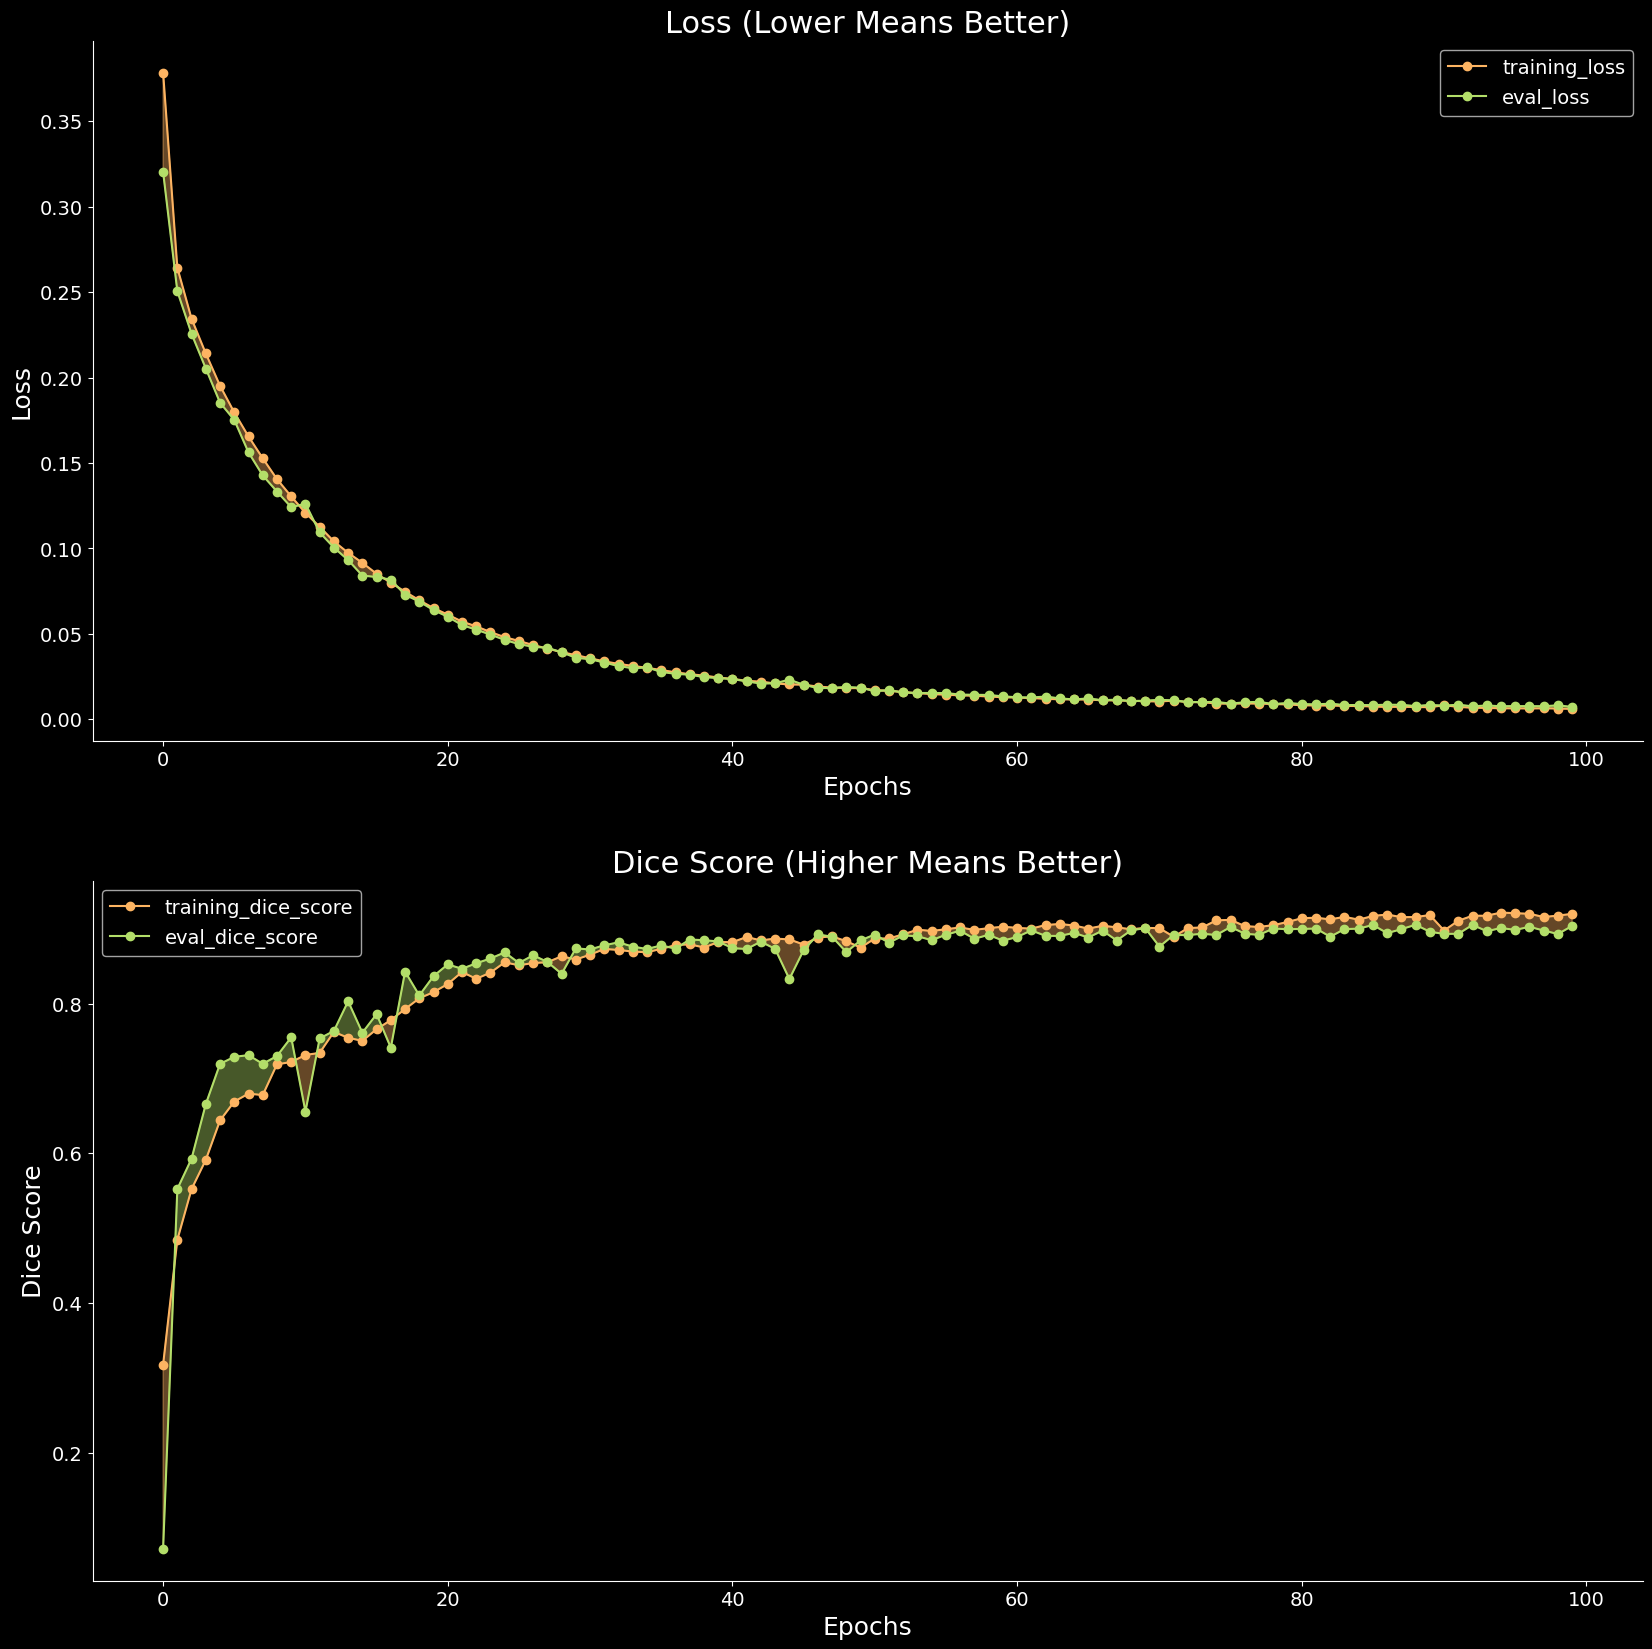

In [40]:
# Plot U-Net Session Training History 
plot_training_curves(
    unet_session_history,
    fig_size=(20, 20)
)

<div class="alert alert-block alert-info">
<h3>Observation</h3>
We see that our model was able to converge to a lower loss for both training and validation sets. We also observe that the model seems to have reached a plateau on both the training and validation dice scores.
</div>

<a id='5.2'></a>
### Generate & Inspect Semantic Segmentation Metrics

To understand what our model is producing, we need to analyse relevant metrics for segmentation. So, to inspect our model's segmentation performance we will inspect the following metrics:


- <b>Accuracy</b>

> The pixel accuracy is the number of correctly classified pixels found in the generated mask. Although it is the simplist metric to compute, it is not the most appropriate metric to analyse in the case of segmentation as most pixels in a segmentation mask will be extremely imbalanced (e.g. a 224x224 mask may only have 5% of pixels which are not blank). This metric will often report an accuracy >90%, but the actual segmentation performance may be worse.

<br>

- <b>Dice Score/Coefficient</b>

> <center>  $\displaystyle Dice Score = 2 \frac{|y_{target} \bigcap y_{pred}|}{|y_{target}| +  |y_{pred}|}$ </center>
<br>
> The Dice coefficient is a popular segmentation metric which measures the overlap between two samples. The metric generates a score ranging between 0 and 1 inclusively where a Dice score of 1 indicating perfect overlap and a score of 0 indicating no overlap. The Dice score is obtained by computing the ratio of the intersection) of the two samples and sum of their element-wise sum. 

<br>

- <b>Jaccard Index (IoU)</b>

> <center> $\displaystyle IoU = \frac{|y_{target} \bigcap y_{pred}|}{|y_{target} \bigcup y_{pred}|}$ </center>
<br>
> The Jaccard Index (also known as Intersection over Union (IoU)) is aa useful metric for evaluating a semantic segmentation model. The IoU is the overlap between the predicted segmentation mask and the actual mask divided by the union area. The IoU ranges between 0-1 with 0 indicating no overlap and 1 indicating a perfect overlap between the actual mask and the generated segmentation mask.

In this section we will also consider the precision and recall metrics. For more information, kindly see the following:
> - [Statology | A Simple Explanation of the Jaccard Similarity Index](https://www.statology.org/jaccard-similarity/)
> - [Jeremy Jordan | Evaluating image segmentation models](https://www.jeremyjordan.me/evaluating-image-segmentation-models/)
> - [Jeremy Jordan | An overview of semantic image segmentation](https://www.jeremyjordan.me/semantic-segmentation/)
> - [Precision and Recall | Essential Metrics for Machine Learning (2023 Update)](https://www.analyticsvidhya.com/blog/2020/09/precision-recall-machine-learning/#What_is_Precision?)

In [41]:
# def accuracy(y_true, y_pred):
#     intersection = (y_true * y_pred).sum()
#     union = (y_true + y_pred).sum() - intersection
#     xor = (y_true == y_pred).sum()
    
#     return (xor / (union + xor - intersection))


def precision_(y_true, y_pred):
    intersection = (y_true * y_pred).sum()
    total_predicted_pixels = y_pred.sum()
    return (intersection / total_predicted_pixels).mean()


def recall_(y_true, y_pred):
    intersection = (y_true * y_pred).sum()
    total_true_pixels = y_true.sum()
    return (intersection / total_true_pixels).mean()


def dice_score(y_true, y_pred):
    eps = 1e-8
    intersection = (y_true * y_pred).sum()
    summation = (y_true + y_pred).sum()
    
    return ((2 * intersection) / (summation + eps))


def jaccard_index(y_true, y_pred):
    eps = 1e-8
    intersection = (y_true * y_pred).sum()
    union = (y_true + y_pred).sum() - intersection
    
    return (intersection / (union + eps))

In [42]:
def compute_metrics(
    model:nn.Module, 
    sample_loader:torch.utils.data.DataLoader,
    device:torch.device) -> np.ndarray:
    
    # Initiate Metrics Dict
    metrics = {
        'accuracy'      : [],
        'precision'     : [],
        'recall'        : [],
        'dice_score'    : [],
        'IoU'           : []
    }
    
    # Set model into eval mode
    model.eval()
    
    # Active inferene context manager
    with torch.inference_mode():
        # Execute eval loop over dataloader
        for batch, (X, y) in enumerate(tqdm(sample_loader)):
            # Load data onto target device
            X, y = X.to(device), y.to(device)

            # Feed-forward Input
            y_pred = model(X) 
            
            # Generate Predicted Masks
            predicted_class = torch.sigmoid(y_pred)
            predicted_class = (predicted_class > 0.3).float()
            
            # Compute Batch Metrics For Each Mask
            for true_mask, pred_mask in zip(y, predicted_class):
                acc = ((true_mask == pred_mask).sum() / torch.numel(true_mask)).cpu().item()
                prec = precision_(true_mask, pred_mask).cpu().item()
                rec = recall_(true_mask, pred_mask).cpu().item()
                dice = dice_score(true_mask, pred_mask).cpu().item()
                iou = jaccard_index(true_mask, pred_mask).cpu().item()
                
                # Record metrics
                metrics['accuracy'].append(acc)
                metrics['precision'].append(prec)
                metrics['recall'].append(rec)
                metrics['dice_score'].append(dice)
                metrics['IoU'].append(iou)
        
    return metrics

In [43]:
# Generate Segmentation Metrics
unet_metrics = compute_metrics(
    unet_model, test_loader, CFG.DEVICE
)

  0%|          | 0/12 [00:00<?, ?it/s]

In [44]:
# Create copy of test df
unet_test_df = test_df.copy()

# Concatenate Metrics onto copied df
unet_test_df = pd.concat(
    (unet_test_df, pd.DataFrame(unet_metrics)), 
    axis=1
)

# Generate diagnosis labels
unet_test_df['model_diagnosis'] = [
    int(mask.max()) for mask in unet_test_masks
]

# View df
unet_test_df

id                patient  \
0    22  TCGA_DU_A5TS_19970726   
1    11  TCGA_DU_8165_19970205   
2    58  TCGA_HT_7881_19981015   
3    19  TCGA_DU_5853_19950823   
4     1  TCGA_DU_7298_19910324   
..   ..                    ...   
762  29  TCGA_DU_6399_19830416   
763   4  TCGA_DU_7294_19890104   
764  11  TCGA_HT_8105_19980826   
765  22  TCGA_DU_7014_19860618   
766  58  TCGA_DU_6405_19851005   

                                            image_path  \
0    /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
1    /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
2    /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
3    /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
4    /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
..                                                 ...   
762  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
763  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
764  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
765  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
766  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   

                                             mask_path  diagnosis  accuracy  \
0    /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...          1  0.998266   
1    /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...          0  1.000000   
2    /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...          0  1.000000   
3    /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...          0  1.000000   
4    /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...          0  1.000000   
..                                                 ...        ...       ...   
762  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...          1  0.998146   
763  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...          0  1.000000   
764  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...          0  1.000000   
765  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...          1  0.995894   
766  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...          0  1.000000   

     precision    recall  dice_score       IoU  model_diagnosis  
0     0.868106  0.918782    0.892725  0.806236                1  
1          NaN       NaN    0.000000  0.000000                0  
2          NaN       NaN    0.000000  0.000000                0  
3          NaN       NaN    0.000000  0.000000                0  
4          NaN       NaN    0.000000  0.000000                0  
..         ...       ...         ...       ...              ...  
762   0.856908  0.988615    0.918062  0.848534                1  
763        NaN       NaN    0.000000  0.000000                0  
764        NaN       NaN    0.000000  0.000000                0  
765        NaN  0.000000    0.000000  0.000000                0  
766        NaN       NaN    0.000000  0.000000                0  

[767 rows x 11 columns]

In [45]:
# Get segmentation metrics for all samples
overall_metrics = dict(
    unet_test_df[unet_metrics.keys()]
    .mean()
)

# Get segmentation metrics for non-diagnosed samples
non_diagnosed_metrics = dict(
    unet_test_df[
        unet_test_df['diagnosis'] == 0
    ][unet_metrics.keys()].mean()
)

# Get segmentation metrics for diagnosed samples
diagnosed_metrics = dict(
    unet_test_df[
        unet_test_df['diagnosis'] == 1
    ][unet_metrics.keys()].mean()
)

# Compile metrics into dataframe
segmetation_metrics = pd.DataFrame({
    'overall_metrics': overall_metrics,
    'non_diagnosed_metrics': non_diagnosed_metrics,
    'diagnosed_metrics': diagnosed_metrics,  
}).T

# View segmetation metrics df
segmetation_metrics

accuracy  precision    recall  dice_score       IoU
overall_metrics        0.997745   0.795368  0.852853    0.280552  0.251145
non_diagnosed_metrics  0.999907   0.000000       NaN    0.000000  0.000000
diagnosed_metrics      0.993720   0.839381  0.852853    0.802923  0.718761

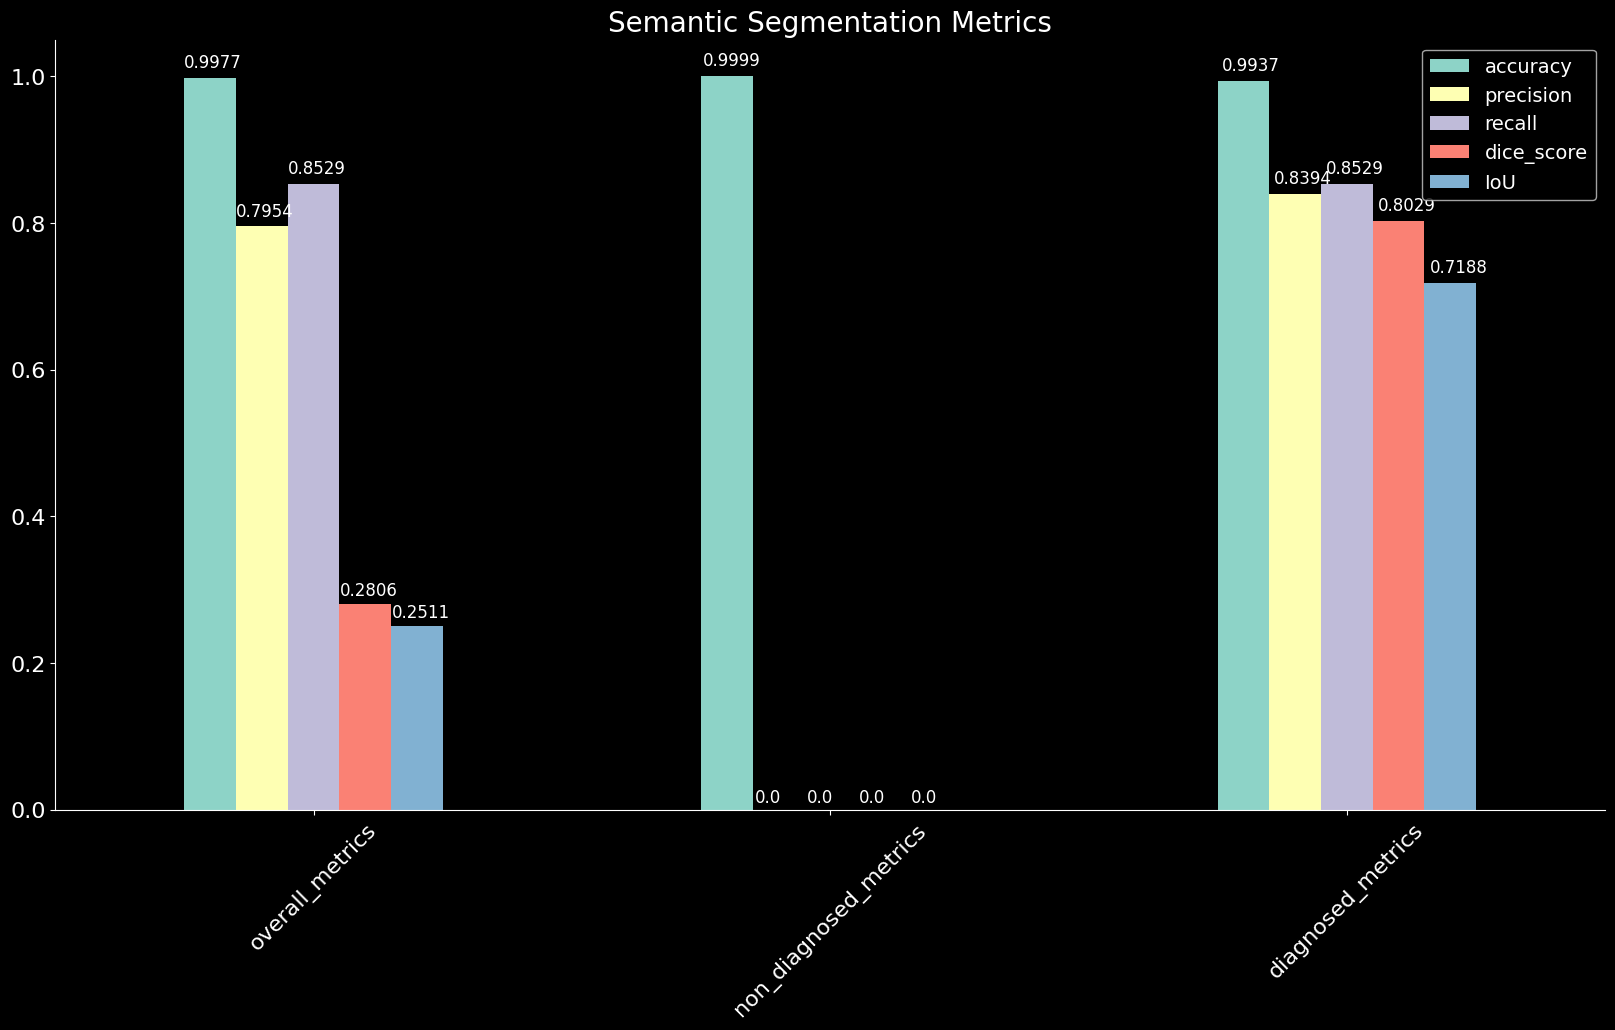

In [46]:
# Plot segmentation metrics bar plot
ax = segmetation_metrics.plot(
    kind="bar", rot=0,
    figsize=(20, 10)
)

# Add legend
ax.legend(bbox_to_anchor=(1.0, 1.0), fontsize=14)

# Display bar values
for p in ax.patches:
    bar_value = p.get_height()
    text = '0.0' if bar_value==0 else f'{bar_value:.4f}'
    ax.annotate(
        text, 
        (p.get_x() * 1.005, p.get_height() * 1.005 + 0.01), 
        fontsize=12
    )

# Update axes tick parameters
ax.tick_params(
    axis='both', which='major', 
    labelsize=16
);

# Rotate x-axis ticks
ax.tick_params(
    axis='x', which='major', 
    labelsize=16, rotation=45
);

# Add title & remove top and right borders w. sns.despine
plt.title('Semantic Segmentation Metrics', fontsize=20);
sns.despine();

<div class="alert alert-block alert-info">
<h3>Observation</h3>
We can observe a stark difference between the validation average dice score (~90%) and the test average dice score (~82%) for the diagnosed cases. This implies that our model is able to produce good semantic segmentation masks, but there is still room for improvement.
</div>

<a id='5.3'></a>
### Generate Diagnosis Confusion Matrix

In [47]:
def plot_confusion_matrix(y_true, y_pred, classes='auto', figsize=(10, 10), text_size=12): 
    # Generate confusion matrix 
    cm = confusion_matrix(y_true, y_pred)
    
    # Set plot size
    plt.figure(figsize=figsize)

    # Create confusion matrix heatmap
    disp = sns.heatmap(
        cm, annot=True, cmap='Greens',
        annot_kws={"size": text_size}, fmt='g',
        linewidths=0.5, linecolor='black', clip_on=False,
        xticklabels=classes, yticklabels=classes)
    
    # Set title and axis labels
    disp.set_title('Confusion Matrix', fontsize=24)
    disp.set_xlabel('Predicted Label', fontsize=20) 
    disp.set_ylabel('True Label', fontsize=20)
    plt.yticks(rotation=0) 

    # Plot confusion matrix
    plt.show()
    
    return

In [48]:
# Get Test True Diagnosis Labels
test_labels = unet_test_df['diagnosis'].to_numpy()

# Get Test Predicted Diagnosis Labels
unet_predictions = unet_test_df['model_diagnosis'].to_numpy()

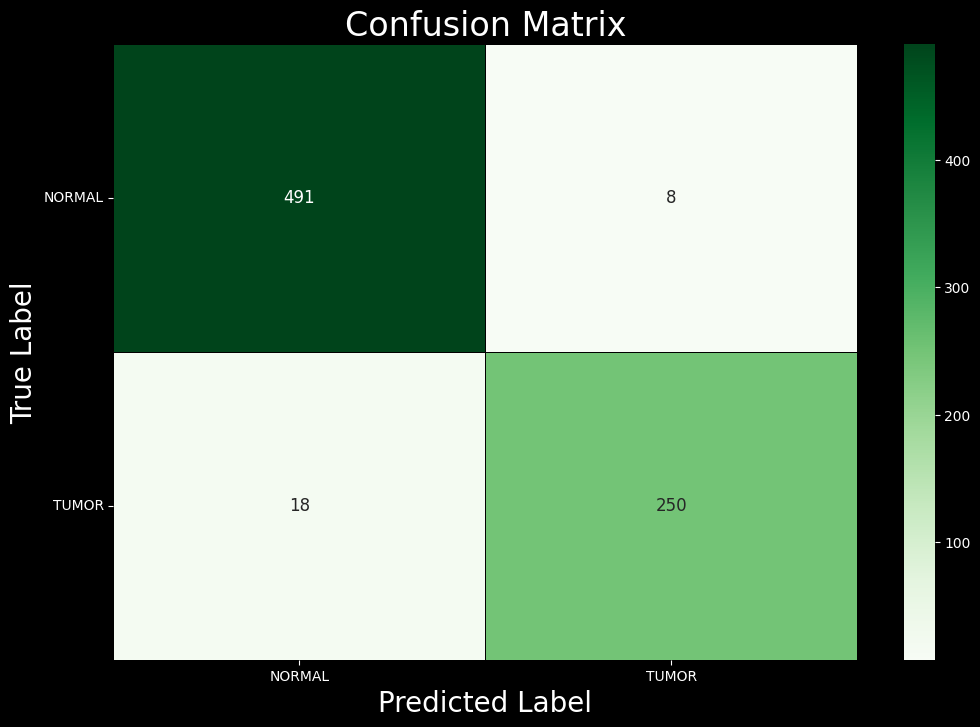

In [49]:
# Plot Confusion Matrix
plot_confusion_matrix(
    test_labels, 
    unet_predictions, 
    figsize=(12, 8),  
    classes=['NORMAL', 'TUMOR']
)

<a id='5.4'></a>
### Inspect Diagnosis Classification Metrics

In [50]:
print(
    classification_report(
        test_labels, 
        unet_predictions, 
        target_names=['NORMAL', 'TUMOR']
))

              precision    recall  f1-score   support

      NORMAL       0.96      0.98      0.97       499
       TUMOR       0.97      0.93      0.95       268

    accuracy                           0.97       767
   macro avg       0.97      0.96      0.96       767
weighted avg       0.97      0.97      0.97       767



In [51]:
def generate_performance_scores(y_true, y_pred, log=True):
    
    model_accuracy = accuracy_score(y_true, y_pred)
    model_precision, model_recall, model_f1, _ = (
        precision_recall_fscore_support(
            y_true, y_pred, average="weighted"
        )
    )    
    model_matthews_corrcoef = matthews_corrcoef(y_true, y_pred)
    
    if log:
        print('=============================================')
        print(f'\nPerformance Metrics:\n')
        print('=============================================')
        print(f'accuracy_score:\t\t{model_accuracy:.4f}\n')
        print('_____________________________________________')
        print(f'precision_score:\t{model_precision:.4f}\n')
        print('_____________________________________________')
        print(f'recall_score:\t\t{model_recall:.4f}\n')
        print('_____________________________________________')
        print(f'f1_score:\t\t{model_f1:.4f}\n')
        print('_____________________________________________')
        print(f'matthews_corrcoef:\t{model_matthews_corrcoef:.4f}\n')
        print('=============================================')
    
    preformance_scores = {
        'accuracy_score'       : model_accuracy,
        'precision_score'      : model_precision,
        'recall_score'         : model_recall,
        'f1_score'             : model_f1,
        'matthews_corrcoef'    : model_matthews_corrcoef
    }
    return preformance_scores

In [52]:
# Generate U-Net model classification performance scores
unet_model_performance = generate_performance_scores(
    test_labels, unet_predictions, log=True
)


Performance Metrics:

accuracy_score:		0.9661

_____________________________________________
precision_score:	0.9662

_____________________________________________
recall_score:		0.9661

_____________________________________________
f1_score:		0.9659

_____________________________________________
matthews_corrcoef:	0.9252



<div class="alert alert-block alert-info">
<h3>Observation</h3>
Our model achieved an f1-score of ~96% for tumour detection, which implies that the model can make quality distinguishments between normal and tumour MRI cases (supported by a high Matthew's Correlation Coefficient (MCC) of ~93% achieved by the model).

<br><br>
The MRI error rate for diagnosing tumour presence is approximately 3%. Since the test set consists of 767 samples, these incorrectly assessed samples should amount to ~23 in total (see the confusion matrix displayed above). In other words, for every 1000 MRI samples we should expect +/- 30 incorrectly diagnosed samples.
</div>

<a id='5.5'></a>
### View Diagnosed Sample Prediction Masks

In [53]:
def view_multiple_predictions(
    model, ds, count=10, 
    color_map='rgb', 
    fig_size=(14, 10), 
    title_size=16):
    
    # Select random samples
    idx = random.sample(
        list(range(len(ds))), 
        count
    )
    
    # Initialise figure
    fig = plt.figure(figsize=fig_size);
    fig.tight_layout();
    fig.subplots_adjust(top=0.95);
    
    # Plot Samples 
    for row, _ in enumerate(idx):
        image, mask = ds[_]
        idx = 3 * (row + 1)
        
        # Plot MRI Image
        plt.subplot(count+1, 3, idx + 1);
        plt.title(f'MRI Image', fontsize=title_size);
        if color_map=='rgb':
            plt.imshow(image.permute(1, 2, 0))
        else:
            plt.imshow(image.permute(1, 2, 0), cmap=color_map)

        # Plot Mask
        plt.subplot(count+1, 3, idx + 2);
        plt.title(f'True Mask', fontsize=title_size)
        
        gen_mask = np.dstack([mask[0]*0.1, mask[0]*0.45, mask[0]*0.1])
        plt.imshow(image.permute(1, 2, 0) + gen_mask);

        # Generate predicted mask
        mri_input = torch.unsqueeze(
            torch.tensor(image), dim=0
        )
        
        # Set inferene context manager to active for predictions
        with torch.inference_mode():
            pred_mask = model(mri_input)
            pred_mask = torch.sigmoid(pred_mask).cpu()
            pred_mask = (pred_mask > 0.5) #threshold of 0.5

        # Plot Predicted Mask 
        plt.subplot(count+1, 3, idx + 3);
        plt.title(f'Predicted Mask', fontsize=title_size)
        
        pred_gen_mask = np.dstack([pred_mask[0][0]*0.3, pred_mask[0][0]*0.2, pred_mask[0][0]*0.8])
        plt.imshow(image.permute(1, 2, 0)+ pred_gen_mask);

    return

In [54]:
# Create Dataset for Diagnosed Sample
test_diagnosed_ds = MRISegmetationDataset(
    unet_test_df[
        unet_test_df['diagnosis'] == 1
    ].reset_index(drop=True), 
    transform=inference_transforms
)

/tmp/ipykernel_26/1527773093.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(image), dim=0


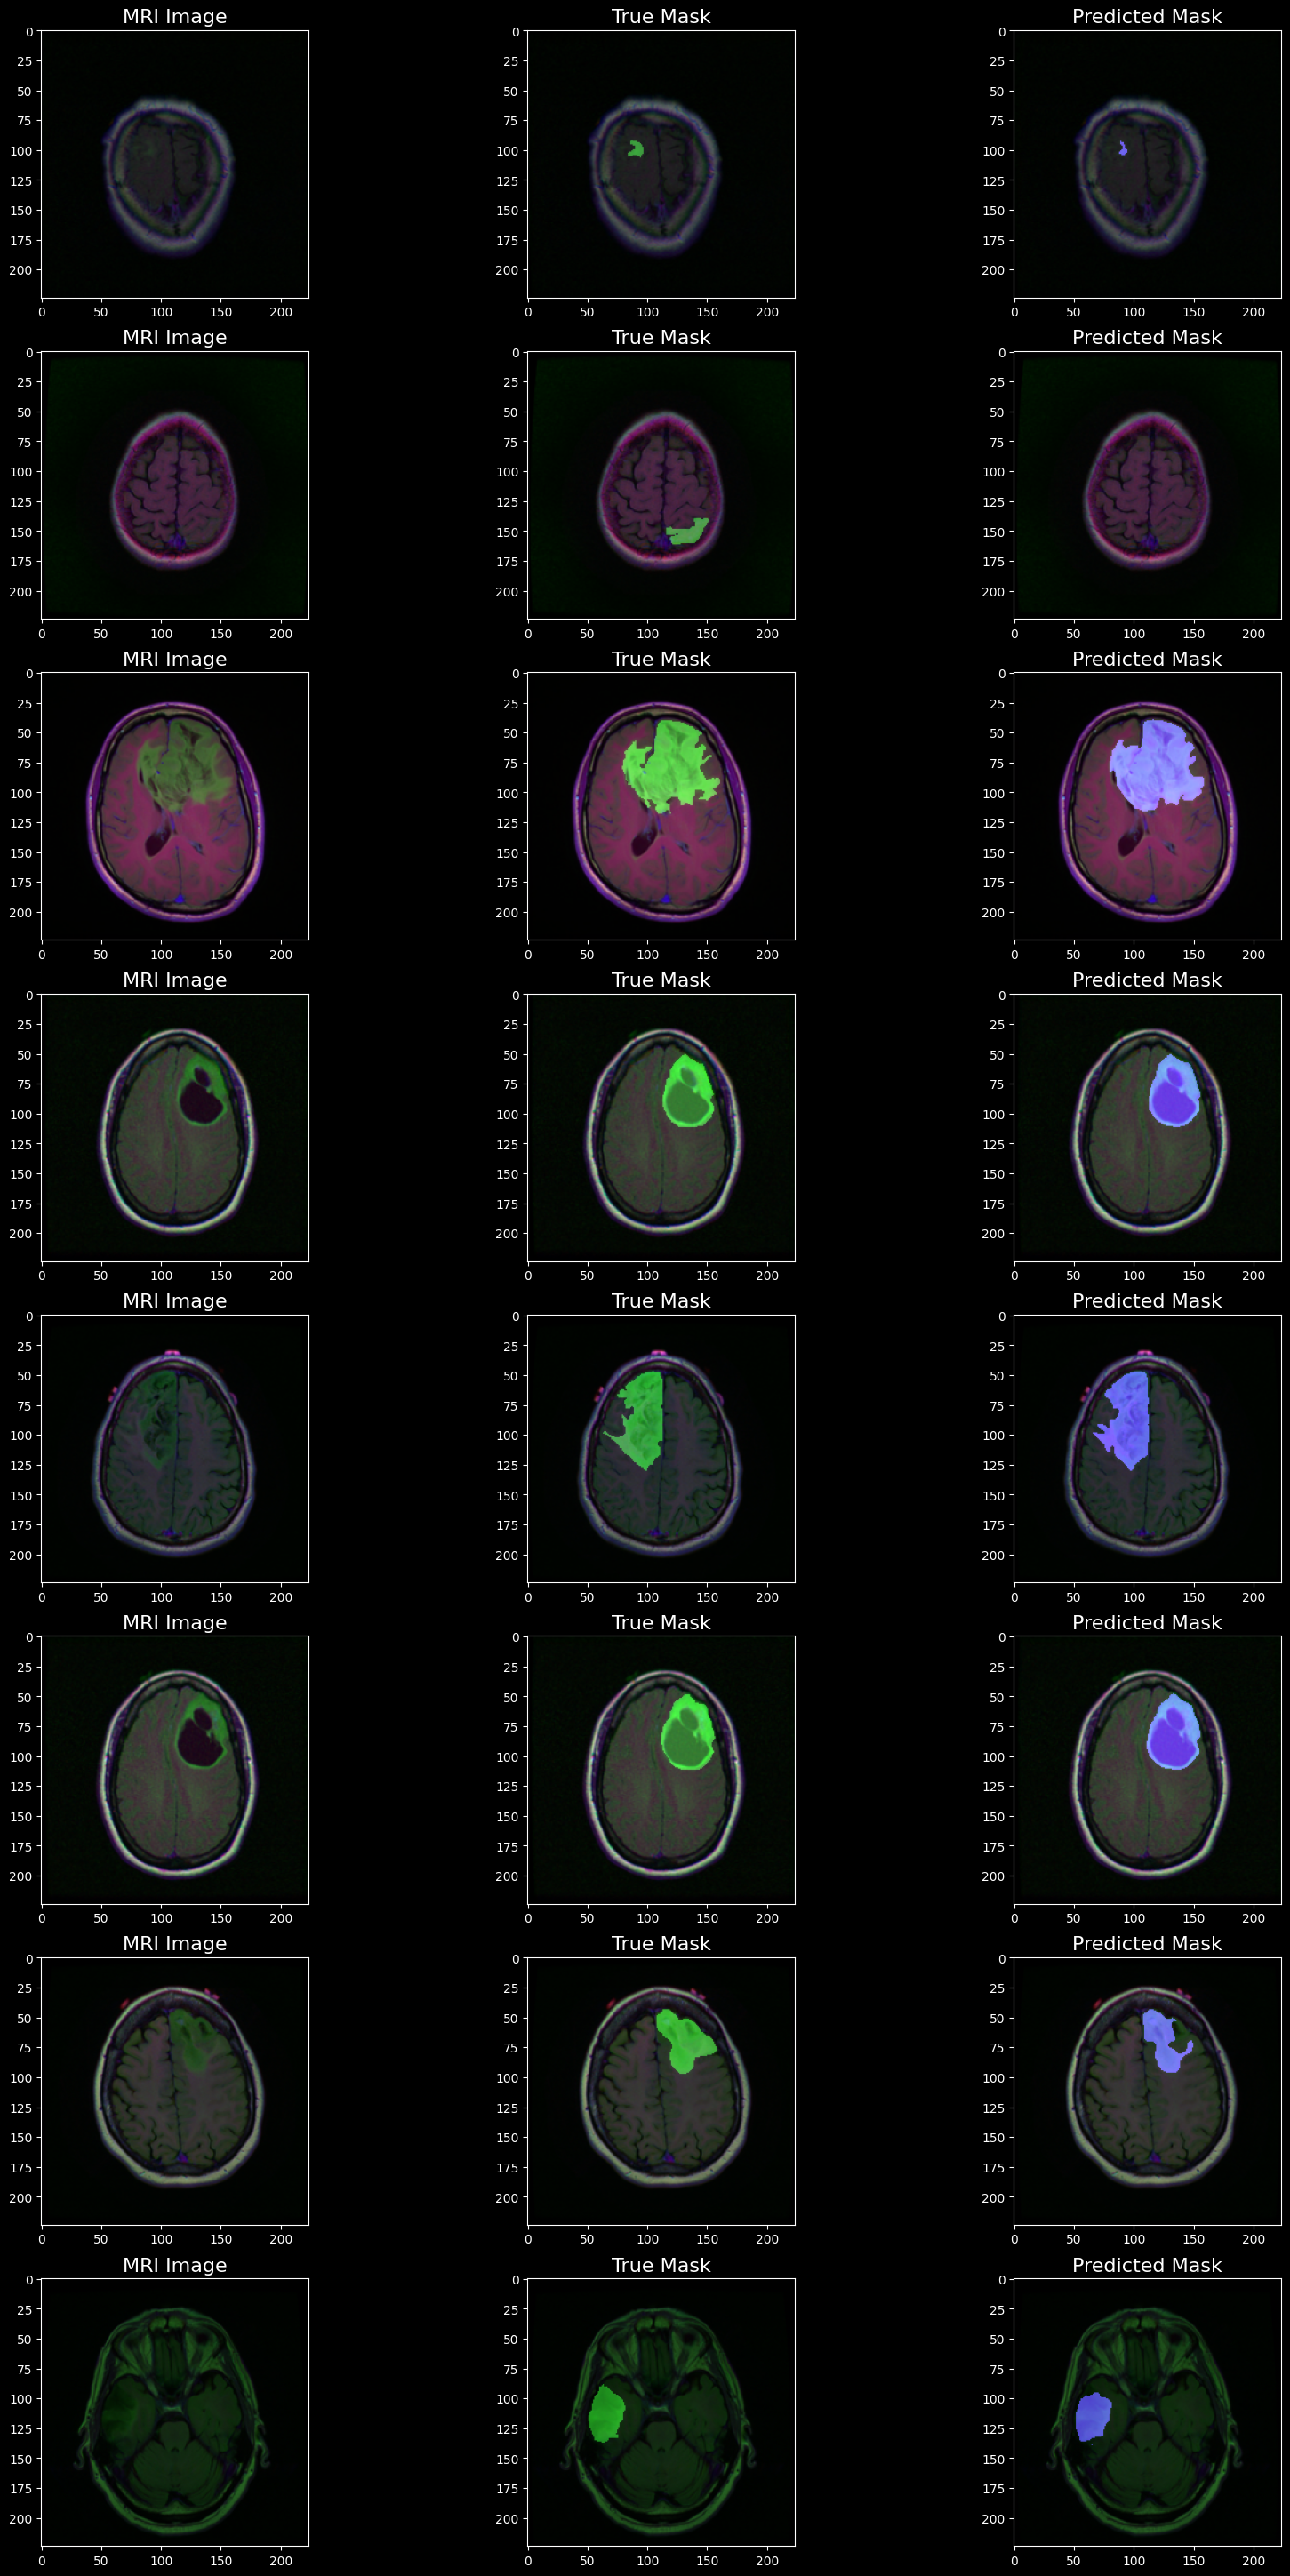

In [55]:
# View Random Samples
view_multiple_predictions(
    unet_model, test_diagnosed_ds, 
    count=8, color_map='rgb',
    fig_size=(20, 38)
)

<div class="alert alert-block alert-info">
<h3>Observation</h3>
We observe that our model is able to generate good segmentation maps. However, it is clear the it struggles to fully segement the MRI samples without producing artifacts. 
</div>

<center><div style='color:#ffffff;
           display:inline-block;
           padding: 5px 5px 5px 5px;
           border-radius:5px;
           background-color:#78D1E1;
           font-size:100%;'><a href=#toc style='text-decoration: none; color:#03001C;'>⬆️ Back To Top</a></div></center>

<a id='conclusion'></a>
# <center>Conclusion</center>
<div style="padding: 4px;color:white;margin:10;font-size:200%;text-align:center;display:fill;border-radius:10px;overflow:hidden;background-image: url(https://i.postimg.cc/j2bBmHWx/Py-Torch-Gradient.jpg); background-size: 100% auto;"></div>

<br>

In this notebook, we've covered the implementation of the U-Net architecture to train a model for segmenting brain tumors in MRIs. We found that the model achieved a Jaccard Index of ~0.73 and a Dice score of ~0.82 on the test set, which indicates that the model can produce decent quality segmentations, but there is room for improvement.

We also discussed the model's capability to generate a diagnosis. We observed that the model achieved an error rate of ~3% for diagnosing normal and tumor cases correctly. This implies that for every 1000 MRI samples, we should expect +/- 30 incorrectly diagnosed samples. Also, we noticed that our model achieved a high Matthew's Correlation Coefficient (MCC) of approximately 93% when diagnosing MRI samples. This indicates that our model exhibits a strong understanding of how to diagnose samples and should be able to effectively diagnose unseen samples.


### Suggestions for improving model performance

To improve the current results achieved by the model covered in this notebook, the following should be considered:

- Using a pre-trained model as a backbone: By using a pre-trained model (such VGG, EfficientNet V2 or DINOv2) as an backbone encoder model, one should be able to achieve improved segmentation and diagnosis performance.

- Training for more epochs: More epochs during training may lead to improved results, but will come at the cost of more training time.

- Using Ensembles: Ensembling multiple models has shown to be effective in many ML problems as it usually leads to improved results. By training more models for ensembling may lead to improved segmentation results, but will certainly require more training time, and result in increased inference time.

The process of detecting brain tumors using AI is challenging and has a very low margin of error. However, if executed accurately, this technology can greatly benefit numerous patients by providing them with the correct diagnosis and timely treatment, potentially saving their lives from fatal outcomes.

<div style="color:white;padding:35px;color:white;margin:10;font-size:120%;text-align:center;display:fill;border-radius:10px;overflow:hidden;background-image: url(https://i.postimg.cc/j2bBmHWx/Py-Torch-Gradient.jpg); background-size: 100% auto;background-position: 0px 0px;">
    <center>
    <span style='color:white'>
    <h3><span style='color:white'><b>I hope this notebook serves the community well!</b></span></h3>
    <h3><span style='color:white'><b>Thank you for visiting! 🙏</b></span></h3>
    </span>
    </center>
</div>